In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import geoplot
import calendar
import folium
import requests
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose


# EDA

## About Data


This dataset provides information on motor vehicle operators (drivers) involved in traffic collisions occurring on county and local roadways. The dataset reports details of all traffic collisions occurring on county and local roadways within Montgomery County, as collected via the Automated Crash Reporting System (ACRS) of the Maryland State Police, and reported by the Montgomery County Police, Gaithersburg Police, Rockville Police, or the Maryland-National Capital Park Police. This dataset shows each collision data recorded and the drivers involved.



## Data Overview

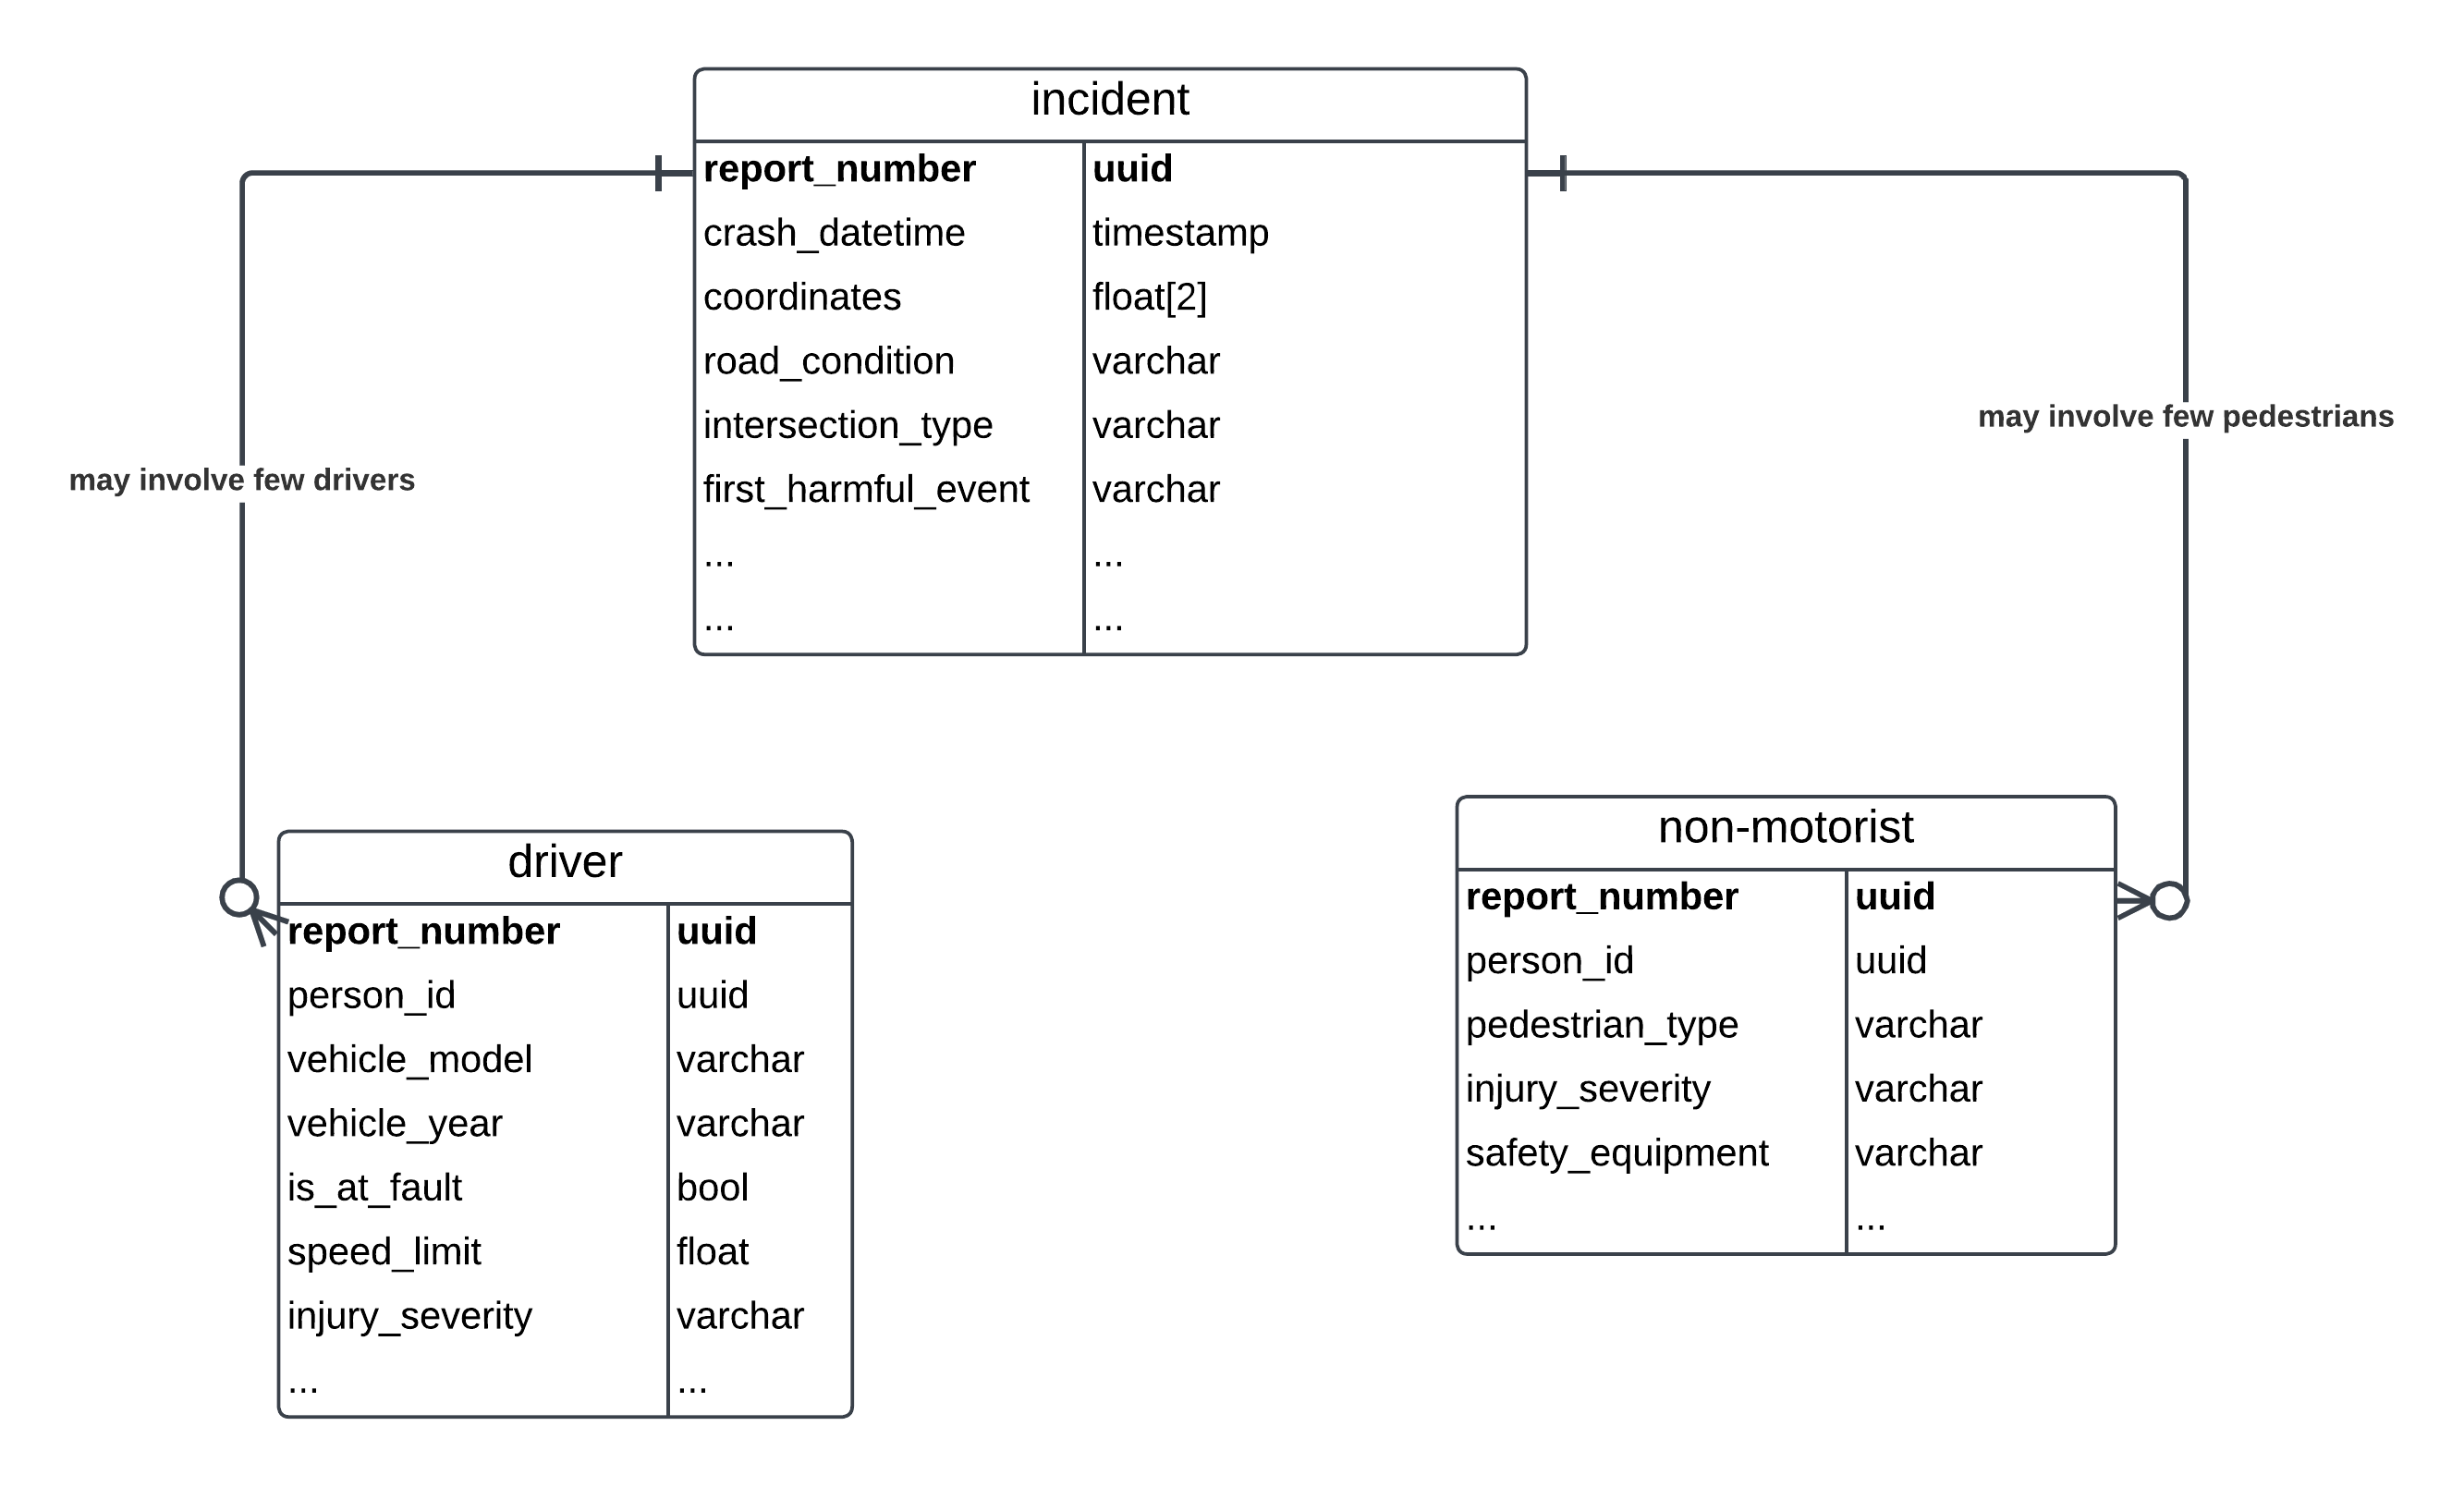

In [2]:
DB_PATH = "data/data.duckdb"

conn = duckdb.connect(database=DB_PATH, read_only=False)

In [3]:
conn.sql("SHOW TABLES;")

┌──────────────┐
│     name     │
│   varchar    │
├──────────────┤
│ drivers      │
│ incidents    │
│ non_motorist │
└──────────────┘

In [4]:
incidents_df = conn.sql("SELECT * FROM incidents;").fetchdf()
drivers_df = conn.sql("SELECT * FROM drivers").fetchdf()
nonmotorist_df = conn.sql("SELECT * FROM non_motorist").fetchdf()

#### Drivers table

In [5]:
conn.sql("SELECT * FROM drivers LIMIT 3;").fetchdf()

report_number  local_case_number                agency_name  \
0    DM8479000T        210020119.0  Takoma Park Police Depart   
1   MCP2970000R         15045937.0                 MONTGOMERY   
2   MCP20160036        180040948.0   Montgomery County Police   

        acrs_report_type      crash_datetime route_type road_name  \
0  Property Damage Crash 2021-05-27 19:40:00       None      None   
1  Property Damage Crash 2015-09-11 13:29:00       None      None   
2  Property Damage Crash 2018-08-17 14:25:00       None      None   

  cross-street_name               off-road_description municipality  ...  \
0              None                     IN PARKING LOT         None  ...   
1              None    Parking Lot: \n2525 Ennalls Ave         None  ...   
2              None  PARKING LOT OF 16246 FREDERICK RD         None  ...   

  speed_limit driverless_vehicle parked_vehicle vehicle_year vehicle_make  \
0           0                 No           True         2017         HINO   
1           5                 No          False         2012       TOYOTA   
2          15                 No          False         2015         MAZD   

  vehicle_model   latitude  longitude                     location  \
0           TWK  38.987657 -76.987545    (38.98765667, -76.987545)   
1            SU  39.039917 -77.053649  (39.03991652, -77.05364898)   
2            TK  38.743373 -77.546997    (38.743373, -77.54699707)   

   vehicle_type_group  
0                None  
1  Passenger Vehicles  
2  Passenger Vehicles  

[3 rows x 40 columns]

In [6]:
drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188090 entries, 0 to 188089
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   report_number                  188090 non-null  object        
 1   local_case_number              188070 non-null  float64       
 2   agency_name                    188090 non-null  object        
 3   acrs_report_type               188090 non-null  object        
 4   crash_datetime                 188090 non-null  datetime64[ns]
 5   route_type                     169696 non-null  object        
 6   road_name                      168741 non-null  object        
 7   cross-street_name              162133 non-null  object        
 8   off-road_description           17356 non-null   object        
 9   municipality                   19126 non-null   object        
 10  related_non-motorist           6040 non-null    object        
 11  

In [7]:
drivers_df["light"].str.upper().value_counts()

light
DAYLIGHT                 127531
DARK LIGHTS ON            39553
DARK NO LIGHTS             4967
DUSK                       4142
DAWN                       3648
DARK LIGHTED               3427
DARK UNKNOWN LIGHTING      1680
NAN                        1445
UNKNOWN                     732
DARK NOT LIGHTED            559
OTHER                       406
Name: count, dtype: int64

#### Incidents table

In [8]:
conn.sql("SELECT * FROM incidents LIMIT 3;").fetchdf()

report_number       crash_datetime  hit lane_direction lane_type  \
0   MCP1123002M  2019-03-04 08:41:00   No         [West]      None   
1   MCP21610009  2016-06-04 19:14:00  Yes         [East]      None   
2   MCP2790000P  2015-08-18 23:00:00   No        [South]      None   

  number_of_lanes direction  distance      road_grade at_fault  \
0               2      EAST     200.0  GRADE DOWNHILL   DRIVER   
1               1      EAST     500.0           LEVEL   DRIVER   
2               2     SOUTH      30.0           LEVEL  UNKNOWN   

  first_harmful_event second_harmful_event          junction  \
0       OTHER VEHICLE                 None  NON INTERSECTION   
1      PARKED VEHICLE        OTHER VEHICLE  NON INTERSECTION   
2      PARKED VEHICLE                 None  NON INTERSECTION   

  intersection_type road_alignment road_condition         road_division  \
0              None       STRAIGHT     NO DEFECTS  TWO-WAY, NOT DIVIDED   
1              None       STRAIGHT     NO DEFECTS  TWO-WAY, NOT DIVIDED   
2              None       STRAIGHT     NO DEFECTS  TWO-WAY, NOT DIVIDED   

   distance_meters  
0           60.960  
1          152.400  
2            9.144

In [9]:
incidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106601 entries, 0 to 106600
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   report_number         106601 non-null  object 
 1   crash_datetime        106601 non-null  object 
 2   hit                   104906 non-null  object 
 3   lane_direction        93146 non-null   object 
 4   lane_type             17547 non-null   object 
 5   number_of_lanes       94261 non-null   object 
 6   direction             93158 non-null   object 
 7   distance              95021 non-null   float64
 8   road_grade            92530 non-null   object 
 9   at_fault              106601 non-null  object 
 10  first_harmful_event   105951 non-null  object 
 11  second_harmful_event  27871 non-null   object 
 12  junction              79122 non-null   object 
 13  intersection_type     50974 non-null   object 
 14  road_alignment        92748 non-null   object 
 15  

In [10]:
incidents_df['road_alignment'].str.upper().value_counts()

road_alignment
STRAIGHT                             81080
CURVE RIGHT                           5569
CURVE LEFT                            5243
OTHER                                  533
UNKNOWN                                131
CURVE LEFT, CURVE RIGHT                 74
CURVE LEFT, STRAIGHT                    69
CURVE RIGHT, STRAIGHT                   47
CURVE LEFT, CURVE RIGHT, STRAIGHT        2
Name: count, dtype: int64

#### Non-motorist table

In [11]:
conn.sql("SELECT * FROM non_motorist LIMIT 3;").fetchdf()

report_number         crash_date/time                             person_id  \
0   MCP9419004R  08/29/2023 02:00:00 PM  EEB1D2F0-0139-453B-8321-D30FC01D3FB7   
1   MCP3353001Z  11/30/2023 04:19:00 PM  2259BC33-1276-46BF-A263-15A1B7E079E5   
2   MCP30750041  10/21/2023 10:34:00 PM  741BDE7D-D991-4C8D-9909-A400AD8C6B8C   

  pedestrian_type pedestrian_movement   pedestrian_actions  \
0           OTHER               Other                OTHER   
1      PEDESTRIAN            Standing  NO IMPROPER ACTIONS   
2           OTHER               Other                OTHER   

  pedestrian_location at_fault         injury_severity safety_equipment  \
0     INSIDE BUILDING       No         POSSIBLE INJURY             NONE   
1               OTHER       No         POSSIBLE INJURY             None   
2               OTHER      Yes  SUSPECTED MINOR INJURY             None   

  pedestrian_category  is_helmet_present  is_lighting_present  \
0               OTHER                0.0                  0.0   
1          PEDESTRIAN                NaN                  NaN   
2               OTHER                NaN                  NaN   

   is_reflective_wear  
0                 0.0  
1                 NaN  
2                 NaN

In [12]:
nonmotorist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250 entries, 0 to 6249
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   report_number        6250 non-null   object 
 1   crash_date/time      6250 non-null   object 
 2   person_id            6250 non-null   object 
 3   pedestrian_type      6250 non-null   object 
 4   pedestrian_movement  6080 non-null   object 
 5   pedestrian_actions   5956 non-null   object 
 6   pedestrian_location  6097 non-null   object 
 7   at_fault             5963 non-null   object 
 8   injury_severity      6250 non-null   object 
 9   safety_equipment     3839 non-null   object 
 10  pedestrian_category  6250 non-null   object 
 11  is_helmet_present    3839 non-null   float64
 12  is_lighting_present  3839 non-null   float64
 13  is_reflective_wear   3839 non-null   float64
dtypes: float64(3), object(11)
memory usage: 683.7+ KB


### Missing Values

In [13]:
def plot_non_null_percentage(non_null_counts, total_rows, color='blue', title="Non null percentage"):
  
    # Calculate percentage of non-null values
    non_null_percentage = (non_null_counts / total_rows) * 100

    # Prepare data for plotting
    data = non_null_percentage.reset_index()
    data.columns = ['Column', 'Non-Null Percentage']

    # Plot
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=data, x='Column', y='Non-Null Percentage', color=color, alpha=0.6)

    # Annotate bars with percentages
    for bar, percentage in zip(barplot.patches, non_null_percentage):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar's center
            bar.get_height(),                 # Y-coordinate at the top of the bar
            f'{percentage:.1f}%',             # Text to display (formatted percentage)
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=10,                      # Font size
            color='black'                     # Font color
        )

    # Add labels and title
    plt.title(title, fontsize=16)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Non-Null Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.ylim(0, 105)  # Set a slightly higher Y-axis limit for better visibility of annotations
    plt.tight_layout()
    plt.show()


In [14]:
incidents_nonnull_counts = incidents_df.count()
drivers_nonnull_counts = drivers_df.count()
nonmotorist_nonnull_counts = nonmotorist_df.count()


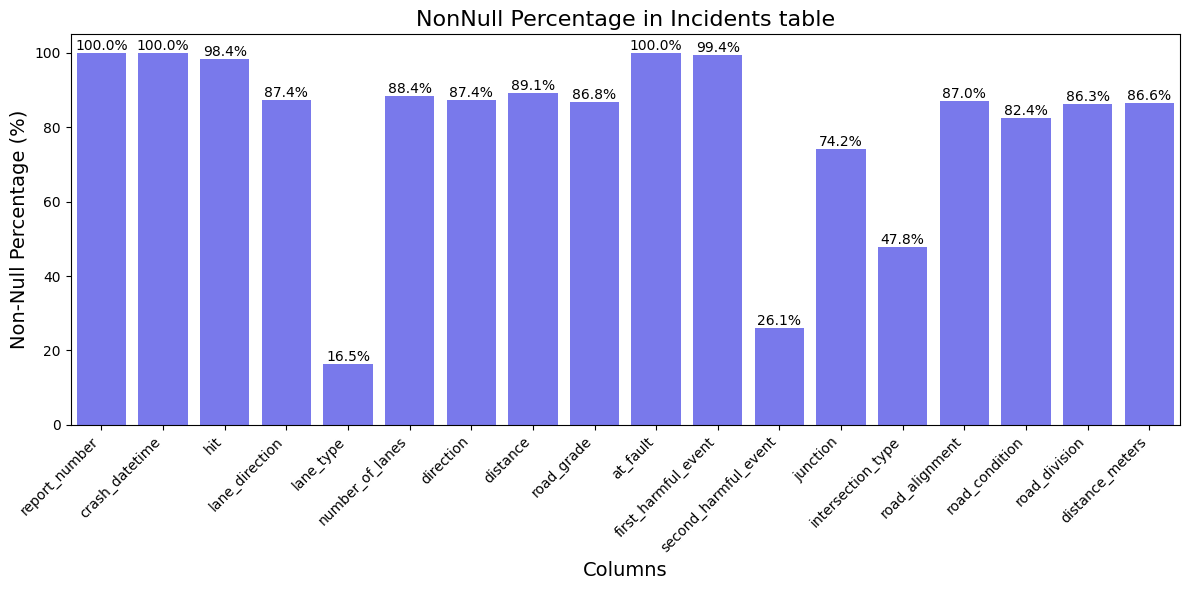

In [15]:
plot_non_null_percentage(incidents_nonnull_counts, len(incidents_df), title="NonNull Percentage in Incidents table")

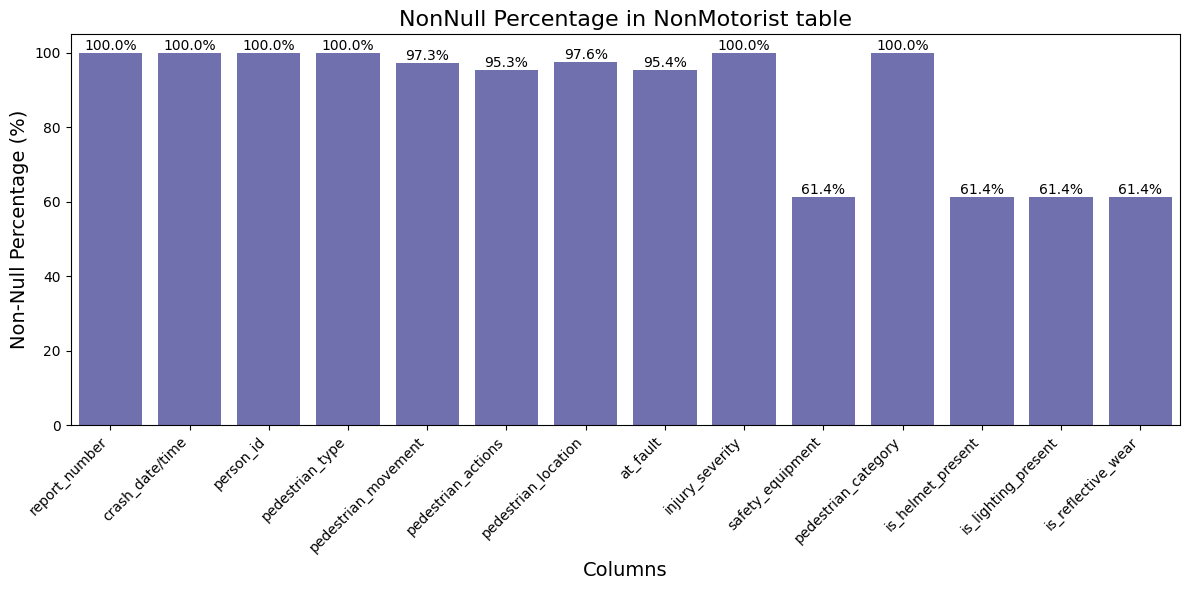

In [16]:
plot_non_null_percentage(nonmotorist_nonnull_counts, len(nonmotorist_df),
                         color="darkblue", title="NonNull Percentage in NonMotorist table")

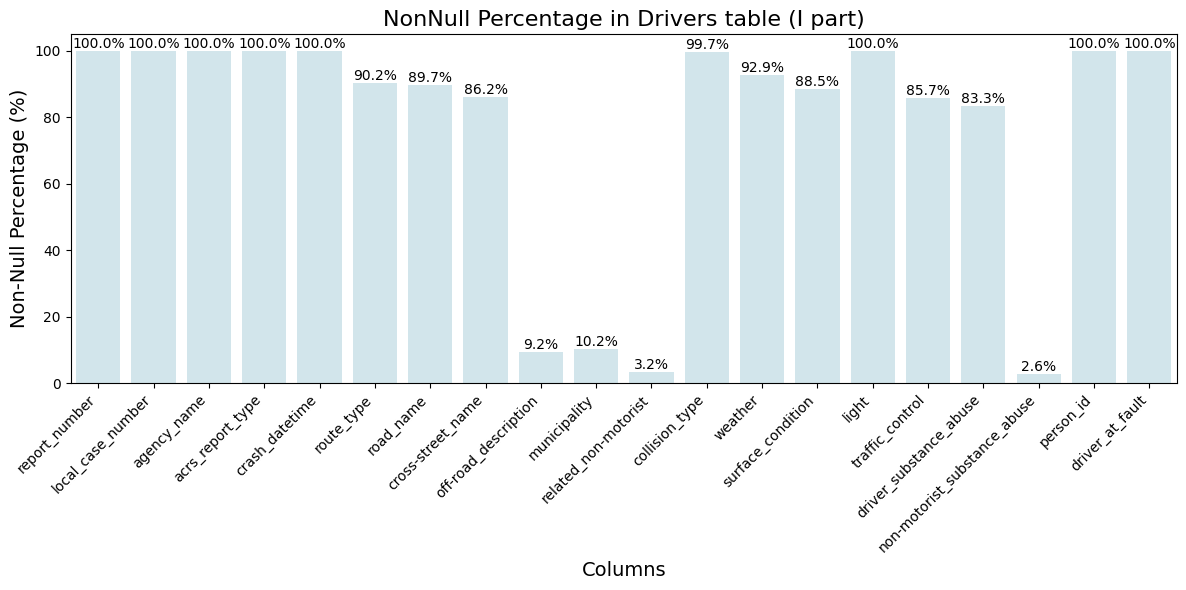

In [17]:
drivers_nonnull_counts_1st = drivers_nonnull_counts[:20]
drivers_nonnull_counts_2nd = drivers_nonnull_counts[20:]


plot_non_null_percentage(drivers_nonnull_counts_1st, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (I part)")

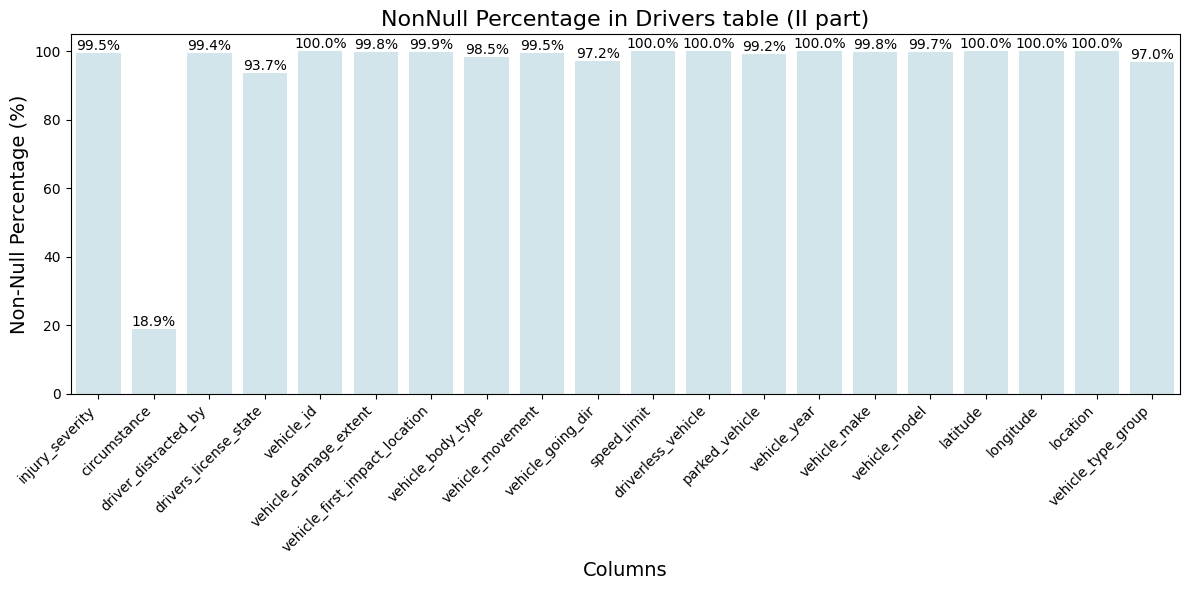

In [18]:
plot_non_null_percentage(drivers_nonnull_counts_2nd, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (II part)")

### Time-Series Analysis: Number of Collisions by Month

#### Definition of Severe/Serious-Injury Collision

A **serious collision** or **severe** is defined as an incident where either a driver or a non-motorist (e.g., pedestrian, cyclist) sustains a **fatal injury** or a **suspected serious injury** requiring hospitalization. Data is derived from collision reports in the `incidents`, `drivers`, and `non_motorist` tables, focusing on injury severities classified as `'FATAL INJURY'` or `'SUSPECTED SERIOUS INJURY'`. Identifying serious collisions is crucial for traffic safety analysis, policy development, and effective resource allocation to reduce severe road incidents and improve emergency responses.

#### Group number of collisions by month

In [19]:
collision_grouped_by_month = conn.sql("""
    SELECT 
        strftime(CAST(crash_datetime AS TIMESTAMP), '%Y') AS year,
        strftime(CAST(crash_datetime AS TIMESTAMP), '%m') AS month,
        COUNT(*) AS number_of_collisions
    FROM incidents
    WHERE CAST(crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01'
    GROUP BY year, month
    ORDER BY year, month;
""").fetchdf()


collision_grouped_by_month["date"] = pd.to_datetime(collision_grouped_by_month['year'].astype(str) + '-' + collision_grouped_by_month['month'])
collision_grouped_by_month['quarter'] = collision_grouped_by_month['date'].dt.to_period('Q').astype(str)
collision_grouped_by_quarter = collision_grouped_by_month.groupby('quarter', as_index=False)['number_of_collisions'].sum()
collision_grouped_by_year = collision_grouped_by_month.groupby('year', as_index=False)['number_of_collisions'].sum()

In [20]:
serious_collision_grouped_by_month = conn.sql("""
    SELECT 
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%Y') AS year,
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%m') AS month,
        COUNT(*) AS number_of_collisions
    FROM incidents I 
    LEFT JOIN drivers D ON I.report_number = D.report_number 
    LEFT JOIN non_motorist NM ON I.report_number = NM.report_number
    WHERE CAST(I.crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01' 
    AND (
        D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
        OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY')
    )
    GROUP BY year, month
    ORDER BY year, month;
""").fetchdf()

serious_collision_grouped_by_month["date"] = pd.to_datetime(serious_collision_grouped_by_month['year'].astype(str) + '-' + serious_collision_grouped_by_month['month'])
serious_collision_grouped_by_month['quarter'] = serious_collision_grouped_by_month['date'].dt.to_period('Q').astype(str)
serious_collision_grouped_by_quarter = serious_collision_grouped_by_month.groupby('quarter', as_index=False)['number_of_collisions'].sum()
serious_collision_grouped_by_year = serious_collision_grouped_by_month.groupby('year', as_index=False)['number_of_collisions'].sum()



#### Plot collisions by month and by year

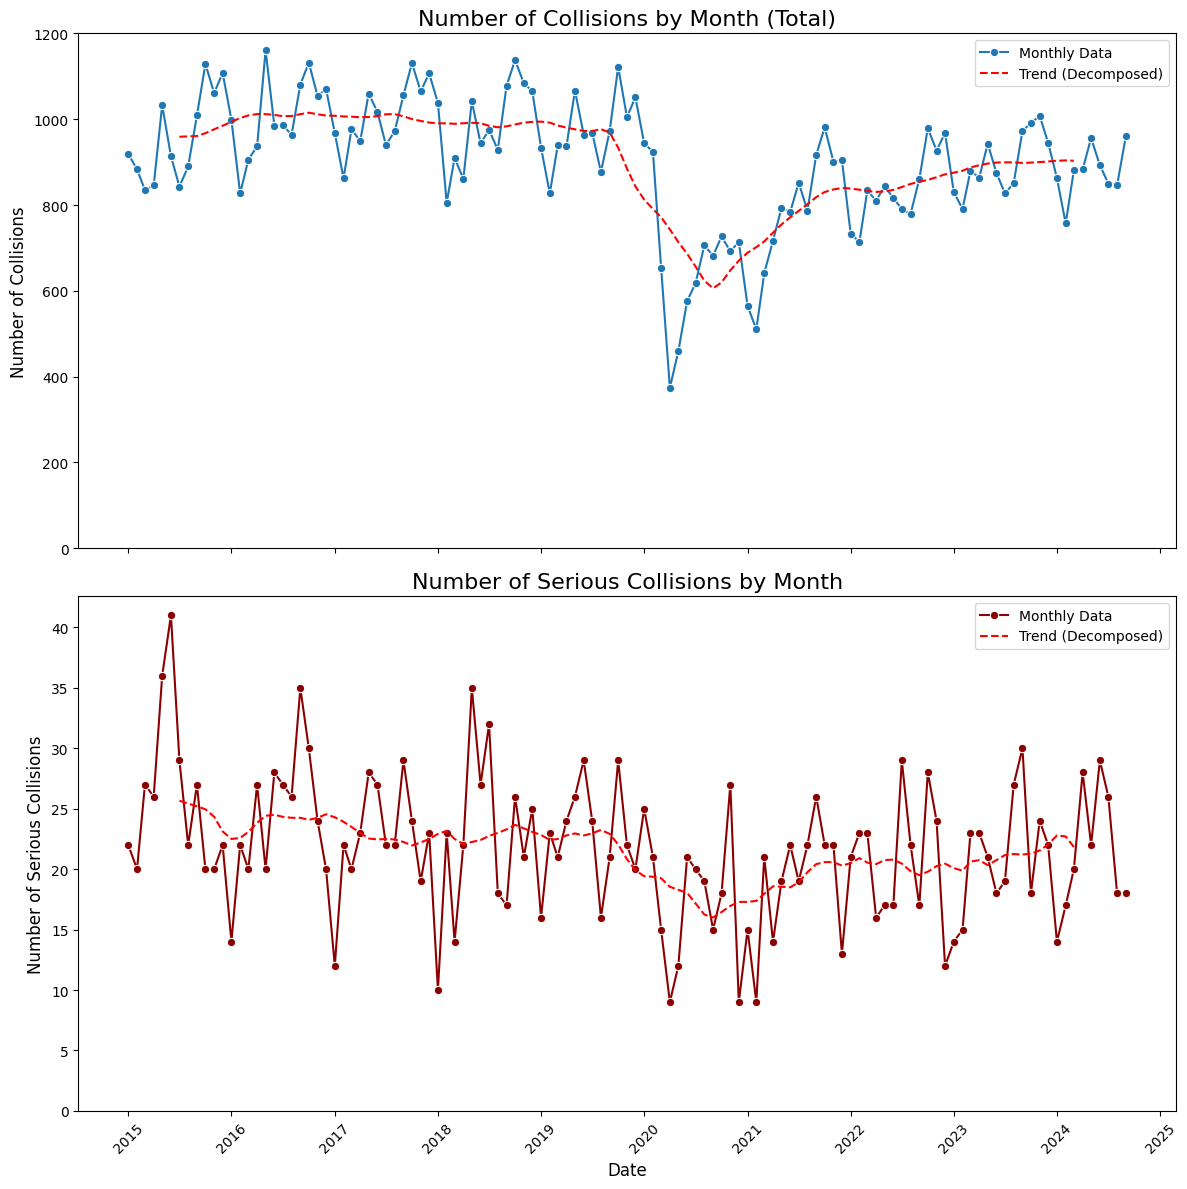

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set index for decomposition for total collisions
collision_grouped_by_month.set_index('date', inplace=True)
decomposition_total = seasonal_decompose(collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
trend_total = decomposition_total.trend
collision_grouped_by_month.reset_index(inplace=True)

# Set index for decomposition for serious collisions
serious_collision_grouped_by_month.set_index('date', inplace=True)
decomposition_serious = seasonal_decompose(serious_collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
trend_serious = decomposition_serious.trend
serious_collision_grouped_by_month.reset_index(inplace=True)

# Create the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot for total collisions
sns.lineplot(data=collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', label='Monthly Data', ax=ax[0])
ax[0].plot(collision_grouped_by_month['date'], trend_total, color='red', label='Trend (Decomposed)', linestyle='--')
ax[0].set_title('Number of Collisions by Month (Total)', fontsize=16)
ax[0].set_ylabel('Number of Collisions', fontsize=12)
ax[0].legend()
ax[0].set_ylim(0)  # Y-axis starts at 0
ax[0].tick_params(axis='x', rotation=45)

# Plot for serious collisions
sns.lineplot(data=serious_collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', label='Monthly Data', color="darkred", ax=ax[1])
ax[1].plot(serious_collision_grouped_by_month['date'], trend_serious, color='red', label='Trend (Decomposed)', linestyle='--')
ax[1].set_title('Number of Serious Collisions by Month', fontsize=16)
ax[1].set_xlabel('Date', fontsize=12)
ax[1].set_ylabel('Number of Serious Collisions', fontsize=12)
ax[1].legend()
ax[1].set_ylim(0)  # Y-axis starts at 0
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


#### Montly seasonality: Total Collisions

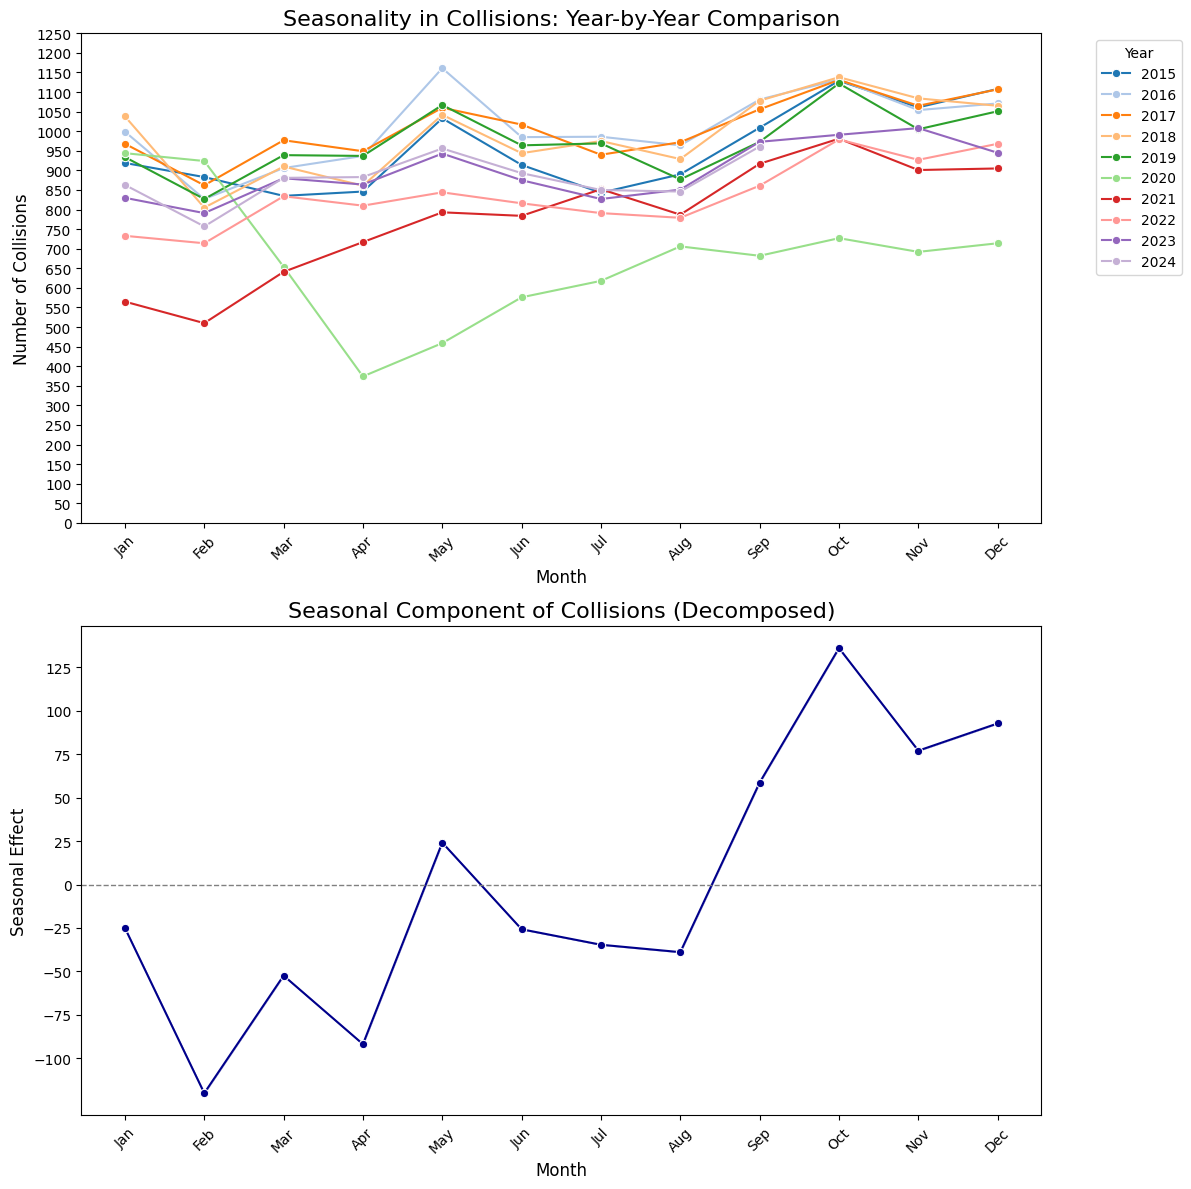

In [22]:
# Ensure the data is time-indexed for decomposition
collision_grouped_by_month.set_index('date', inplace=True)
decomposition = seasonal_decompose(collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
seasonality = decomposition.seasonal
collision_grouped_by_month.reset_index(inplace=True)
collision_grouped_by_month['month_name'] = collision_grouped_by_month['date'].dt.strftime('%b')

seasonal_df = seasonality.reset_index()
seasonal_df['month_name'] = seasonal_df['date'].dt.strftime('%b')
seasonal_df['month_order'] = seasonal_df['month_name'].map(lambda x: list(calendar.month_abbr).index(x))
seasonal_df = seasonal_df.sort_values('month_order')

# Create the figure and axes for two stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

y_ticks = np.arange(0, 1300, 50)

# Top plot: Year-by-year trends
sns.lineplot(
    data=collision_grouped_by_month, 
    x='month_name', 
    y='number_of_collisions', 
    hue='year', 
    marker='o', 
    palette='tab20', 
    ax=axes[0]
)
axes[0].set_title('Seasonality in Collisions: Year-by-Year Comparison', fontsize=16)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1200)
axes[0].set_yticks(y_ticks)

# Bottom plot: Seasonal component from decomposition
sns.lineplot(
    data=seasonal_df, 
    x='month_name', 
    y='seasonal', 
    marker='o', 
    color='darkblue', 
    ax=axes[1]
)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)  # Add horizontal dashed line at zero
axes[1].set_title('Seasonal Component of Collisions (Decomposed)', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Seasonal Effect', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_yticks(np.arange(-100, 126, 25))

# Adjust layout
plt.tight_layout()
plt.show()


**Observations and Comments**

By overlaying collisions for each year, we see a clear and noticeable seasonality in number of collisions. Seasonal effect is highest at October whereas January, February, March and April tend to have small (negative seasonal effect). 

Another observation is Spring of 2020 which is anomaly among all years very likely due to COVID19 pandemy and lockdown. The number of collisions fell down noticably. 
There is an official document from the Governor of State Maryland that require all person to stay at home as much as possible.
[Governor of Maryalnd Order 2020, 30 March](https://health.maryland.gov/massage/Documents/exeorder58.pdf)



#### Montly Seasonality: Severe (Serious-injury) Collisions

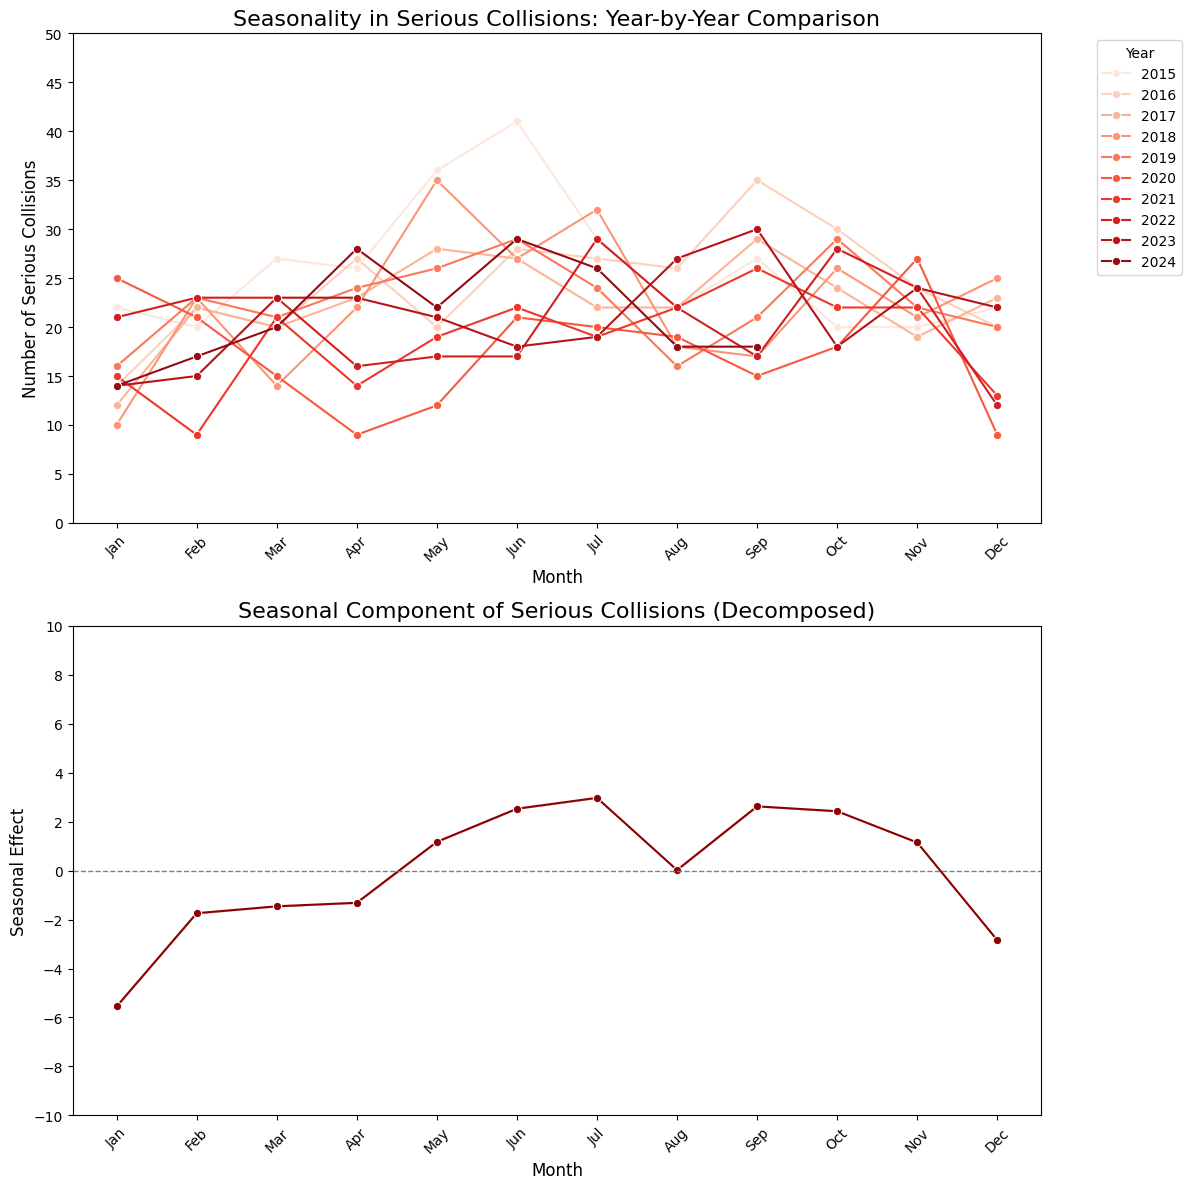

In [23]:
# Ensure the data is time-indexed for decomposition
serious_collision_grouped_by_month.set_index('date', inplace=True)
decomposition = seasonal_decompose(serious_collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
seasonality = decomposition.seasonal
serious_collision_grouped_by_month.reset_index(inplace=True)
serious_collision_grouped_by_month['month_name'] = serious_collision_grouped_by_month['date'].dt.strftime('%b')

# Prepare seasonal data for plotting
seasonal_df = seasonality.reset_index()
seasonal_df['month_name'] = seasonal_df['date'].dt.strftime('%b')
seasonal_df['month_order'] = seasonal_df['month_name'].map(lambda x: list(calendar.month_abbr).index(x))
seasonal_df = seasonal_df.sort_values('month_order')

# Create the figure and axes for two stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

y_ticks = np.arange(0, 51, 5)  # Adjusted for serious collisions

# Top plot: Year-by-year trends (shades of red)
sns.lineplot(
    data=serious_collision_grouped_by_month, 
    x='month_name', 
    y='number_of_collisions', 
    hue='year', 
    marker='o', 
    palette='Reds',  # Use shades of red
    ax=axes[0]
)
axes[0].set_title('Seasonality in Serious Collisions: Year-by-Year Comparison', fontsize=16)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Serious Collisions', fontsize=12)
axes[0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 50)  # Adjusted for serious collisions
axes[0].set_yticks(y_ticks)

# Bottom plot: Seasonal component from decomposition
sns.lineplot(
    data=seasonal_df, 
    x='month_name', 
    y='seasonal', 
    marker='o', 
    color='darkred',  # Use dark red for serious collisions
    ax=axes[1]
)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)  # Add horizontal dashed line at zero
axes[1].set_title('Seasonal Component of Serious Collisions (Decomposed)', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Seasonal Effect', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_yticks(np.arange(-10, 11, 2))  # Adjusted for serious collisions

# Adjust layout
plt.tight_layout()
plt.show()


**Observations and Comments**

Severe collisions tend to have less expressed seasonality and larger variance in some seasons. Looking at seasonal effect, we see that Winter months have noticably fewer severe road incidents in comparison with Summer and Autumn. I also have to notice, though it looks like a significant differnce, this seasonality in severe collisions might be affected by the fact that winter has fewer total collisions on average.


#### Heatmap: yearly collisions by month

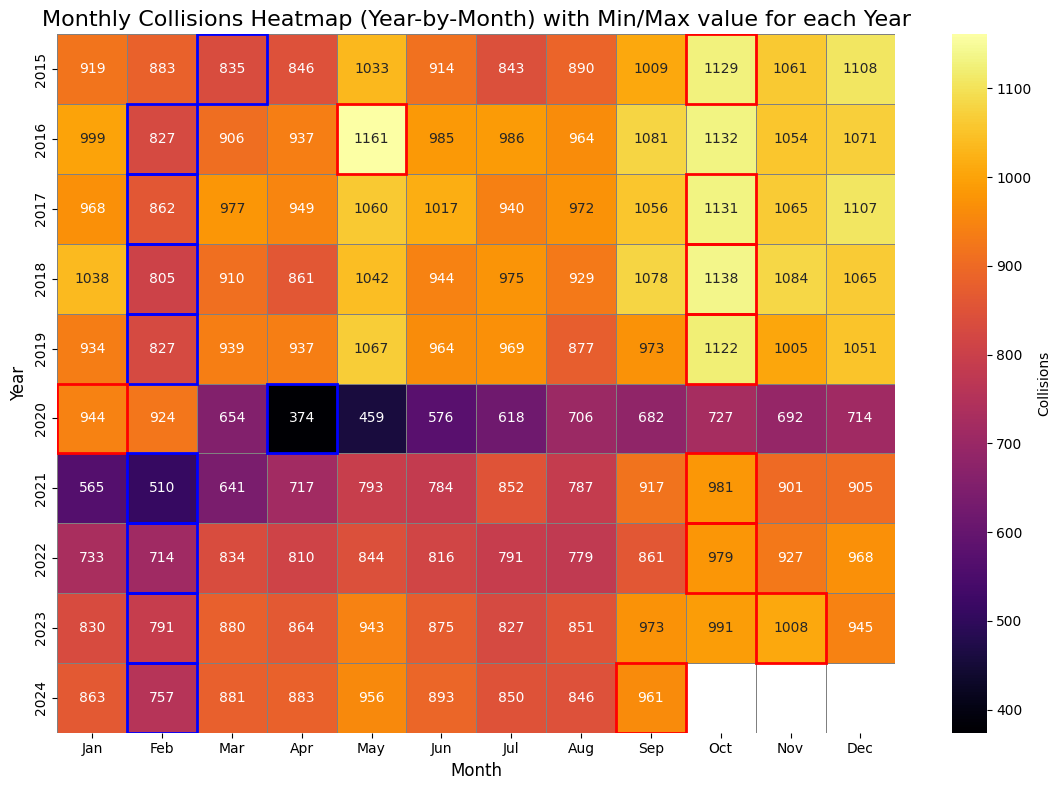

In [24]:
collision_grouped_by_month['month_name'] = collision_grouped_by_month['month'].astype(int).map(lambda x: calendar.month_abbr[x])

# Create a pivot table for heatmap visualization with month names
heatmap_data = collision_grouped_by_month.pivot(index='year', columns='month_name', values='number_of_collisions')

# Ensure columns are sorted by correct month order
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
heatmap_data = heatmap_data[month_order]  # Reorder columns based on month order

# Create masks for min and max values
min_mask = heatmap_data.eq(heatmap_data.min(axis=1), axis=0)
max_mask = heatmap_data.eq(heatmap_data.max(axis=1), axis=0)

# Plot the base heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    cmap='inferno', 
    annot=True, 
    fmt='.0f', 
    cbar_kws={'label': 'Collisions'}, 
    linewidths=0.5,
    linecolor='gray',
    square=True
)

# Add borders for min and max values
for i in range(heatmap_data.shape[0]):  # Iterate over rows (years)
    for j in range(heatmap_data.shape[1]):  # Iterate over columns (months)
        if min_mask.iloc[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='blue', lw=2))
        elif max_mask.iloc[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

# Add title and labels
plt.title('Monthly Collisions Heatmap (Year-by-Month) with Min/Max value for each Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

#### Time-Series Diagnostics: Total Colisions

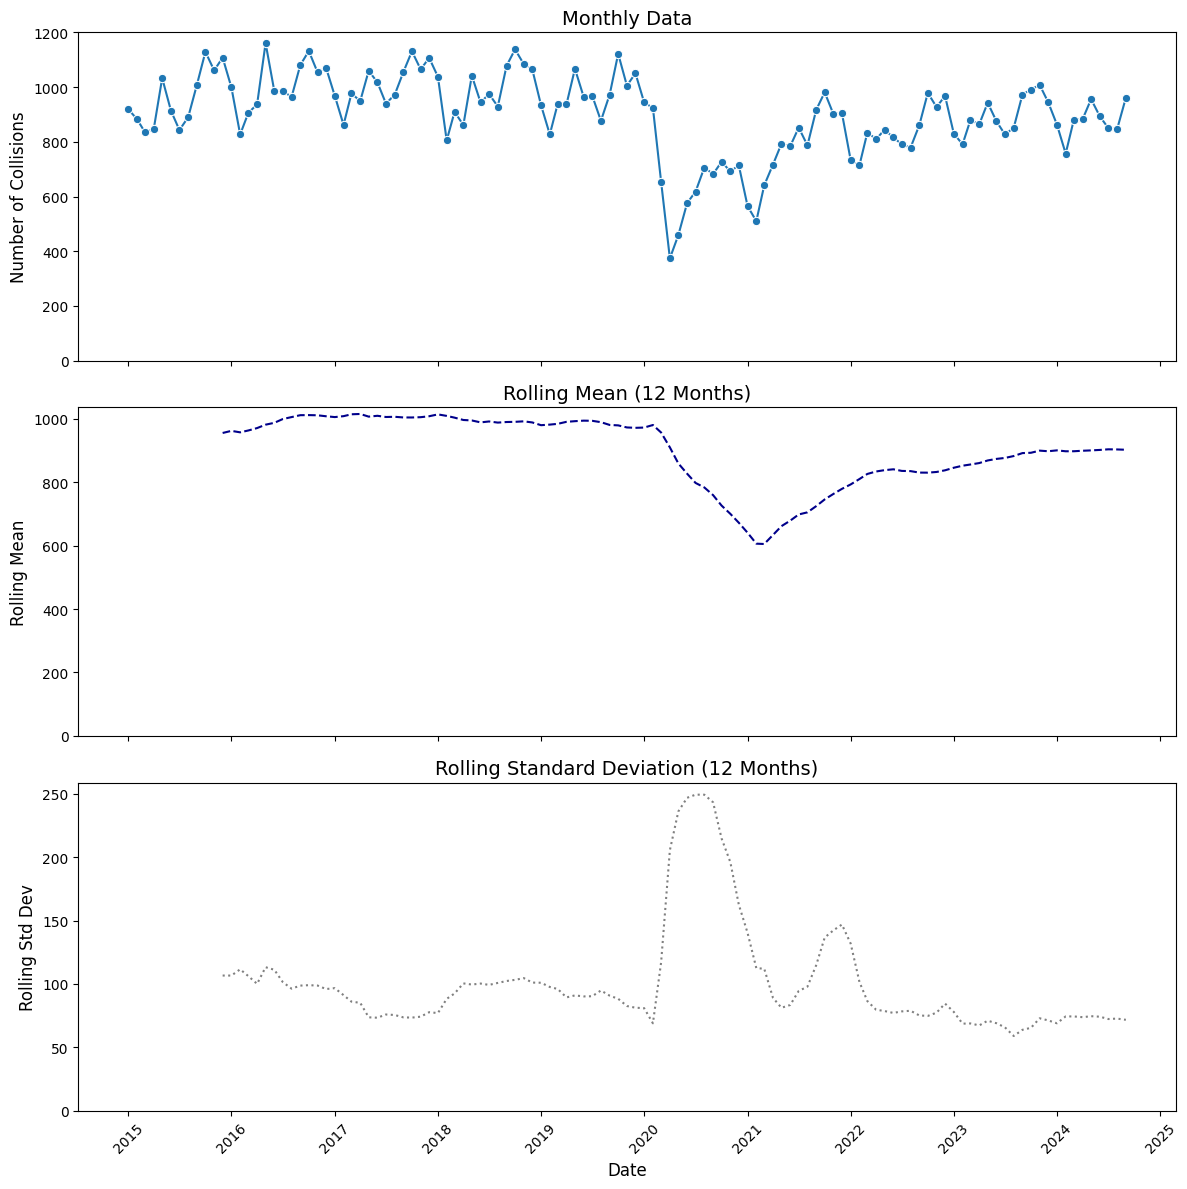

In [25]:
# Compute rolling statistics
rolling_mean = collision_grouped_by_month['number_of_collisions'].rolling(window=12).mean()
rolling_std = collision_grouped_by_month['number_of_collisions'].rolling(window=12).std()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot the original time series
sns.lineplot(data=collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', ax=axes[0])
axes[0].set_title('Monthly Data', fontsize=14)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling mean
axes[1].plot(collision_grouped_by_month['date'], rolling_mean, color="darkblue", linestyle='--')
axes[1].set_title('Rolling Mean (12 Months)', fontsize=14)
axes[1].set_ylabel('Rolling Mean', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling standard deviation
axes[2].plot(collision_grouped_by_month['date'], rolling_std, color='gray', linestyle=':')
axes[2].set_title('Rolling Standard Deviation (12 Months)', fontsize=14)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Rolling Std Dev', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0)  # Ensure y-axis starts at 0

# Adjust layout
plt.tight_layout()
plt.show()


 **Observations and Comments**

As mentioned earlier, we have identified clear seasonality in the time series of collisions in Maryland State. These diagnostic plots can be interpreted as follows:

1. **2020 is an anomaly and a structural break in our time series.**
2. **The number of collisions as a time series is not stationary due to Spring 2020 and non-constant variance.**
3. **Modeling this series may be feasible if we preprocess and smooth the outlier in 2020.**  
   - This can be achieved through interpolation between 2020 and 2021 or by using another technique.


#### Time-Series Diagnostics: Severe Collisions

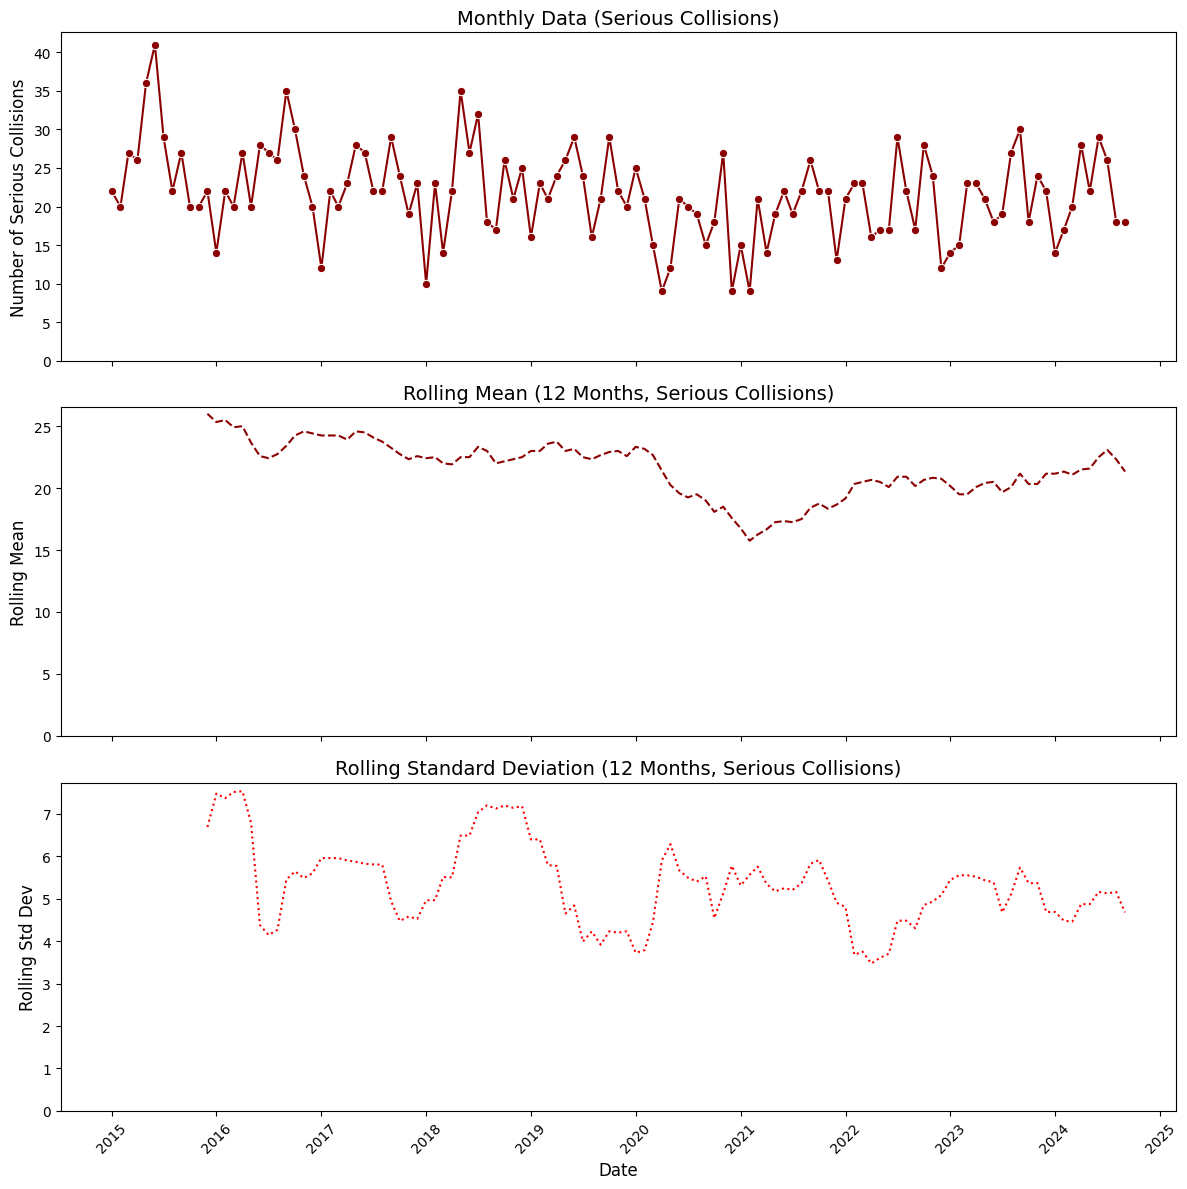

In [26]:
# Compute rolling statistics for serious collisions
rolling_mean_serious = serious_collision_grouped_by_month['number_of_collisions'].rolling(window=12).mean()
rolling_std_serious = serious_collision_grouped_by_month['number_of_collisions'].rolling(window=12).std()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot the original time series for serious collisions
sns.lineplot(data=serious_collision_grouped_by_month, x='date', y='number_of_collisions', color="darkred", marker='o', ax=axes[0])
axes[0].set_title('Monthly Data (Serious Collisions)', fontsize=14)
axes[0].set_ylabel('Number of Serious Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling mean for serious collisions
axes[1].plot(serious_collision_grouped_by_month['date'], rolling_mean_serious, color="darkred", linestyle='--')
axes[1].set_title('Rolling Mean (12 Months, Serious Collisions)', fontsize=14)
axes[1].set_ylabel('Rolling Mean', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling standard deviation for serious collisions
axes[2].plot(serious_collision_grouped_by_month['date'], rolling_std_serious, color='red', linestyle=':')
axes[2].set_title('Rolling Standard Deviation (12 Months, Serious Collisions)', fontsize=14)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Rolling Std Dev', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0)  # Ensure y-axis starts at 0

# Adjust layout
plt.tight_layout()
plt.show()


#### Different Circumstances of Collisions

In [68]:
incidents_with_circumstances = conn.sql("""
SELECT 
    I.report_number,
    I.crash_datetime,
    CASE 
        WHEN D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
             OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY')
        THEN 1
        ELSE 0
    END AS severity,

    -- Binary flag for no traffic control
    CASE 
        WHEN UPPER(D.traffic_control) = 'NO CONTROLS' THEN 0
        ELSE 1
    END AS traffic_control,

    -- Binary flag for light condition containing 'LIGHT'
    CASE 
        WHEN UPPER(D.light) LIKE '%LIGHT%' THEN 1
        ELSE 0
    END AS light,

    -- Binary flag for pedestrian involvement
    CASE 
        WHEN NM.report_number IS NOT NULL THEN 1
        ELSE 0
    END AS pedestrian_involved,

    CASE 
        WHEN D.driver_distracted_by = 'NOT DISTRACTED' THEN 'NOT DISTRACTED'
        WHEN D.driver_distracted_by = 'UNKNOWN' THEN 'UNKNOWN'        
        ELSE 'DISTRACTED'
    END AS driver_distraction,
        
    UPPER(I.first_harmful_event) AS first_harmful_event,
    
    CASE
        WHEN 'ALCOHOL CONTRIBUTED' IN D.driver_substance_abuse THEN 1
        ELSE 0
    END AS is_alcohol_present_driver
    
FROM incidents I
LEFT JOIN drivers D 
    ON I.report_number = D.report_number
LEFT JOIN non_motorist NM 
    ON I.report_number = NM.report_number
WHERE D.location IS NOT NULL 
  AND CAST(I.crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01'
ORDER BY I.crash_datetime;
""").fetchdf()


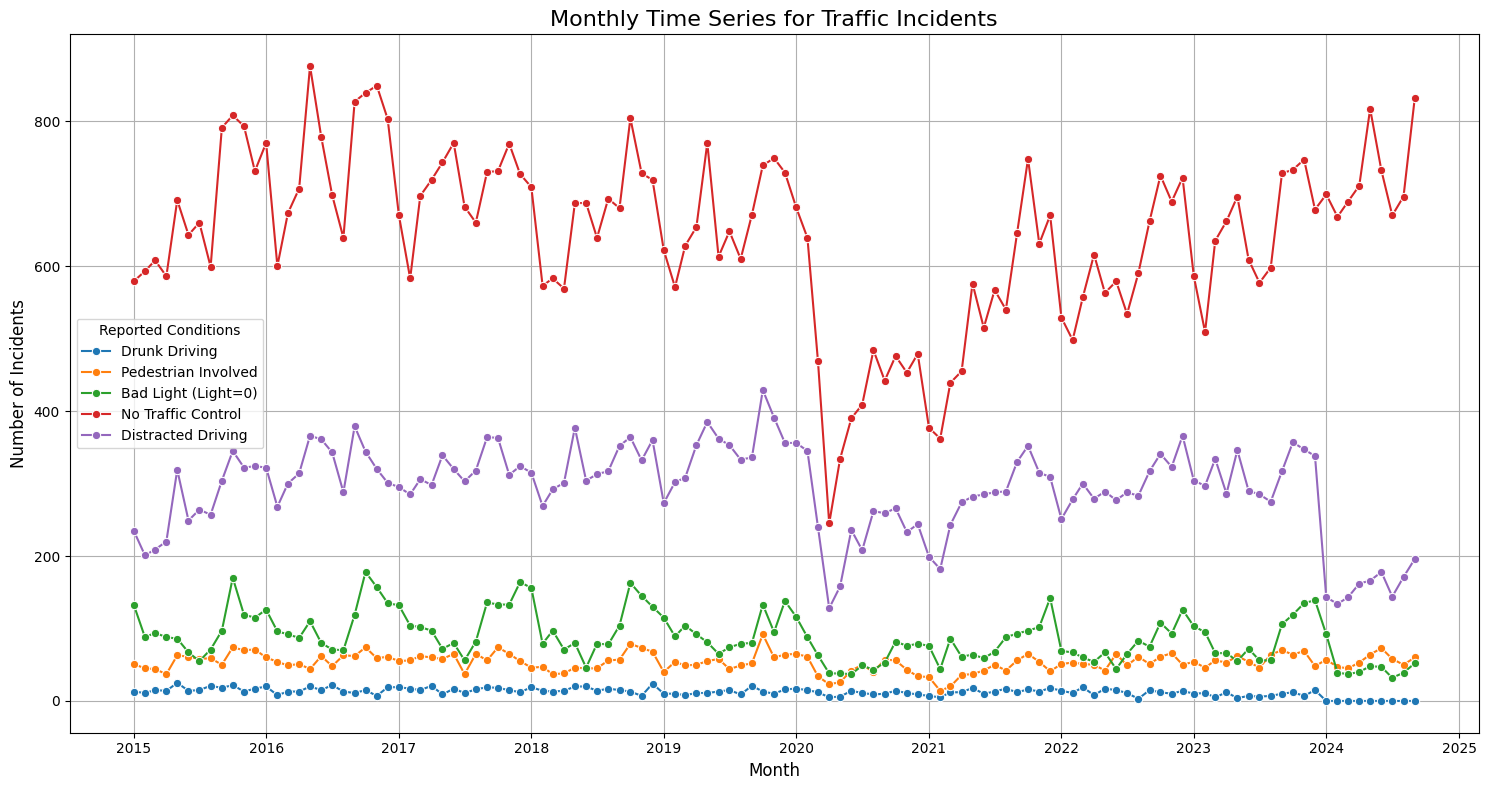

In [71]:
# Preprocessing
incidents_with_circumstances['crash_datetime'] = pd.to_datetime(incidents_with_circumstances['crash_datetime'])
incidents_with_circumstances['month'] = incidents_with_circumstances['crash_datetime'].dt.to_period('M')

# Aggregate monthly counts for each condition
monthly_counts = incidents_with_circumstances.groupby('month').agg({
    'is_alcohol_present_driver': 'sum',
    'pedestrian_involved': 'sum',
    'light': lambda x: (x == 0).sum(),  # Count bad light (light=0)
    'traffic_control': lambda x: (x == 0).sum(),  # Count no traffic control (traffic_control=0)
    'driver_distraction': lambda x: (x == 'DISTRACTED').sum()  # Count distracted driving
}).reset_index()

# Convert 'month' to datetime for plotting
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

# Plotting
plt.figure(figsize=(15, 8))

conditions = {
    'is_alcohol_present_driver': 'Drunk Driving',
    'pedestrian_involved': 'Pedestrian Involved',
    'light': 'Bad Light (Light=0)',
    'traffic_control': 'No Traffic Control',
    'driver_distraction': 'Distracted Driving'
}

# Plot each condition on the same axis
for col, label in conditions.items():
    sns.lineplot(data=monthly_counts, x='month', y=col, marker='o', label=label)

# Customization
plt.title('Monthly Time Series for Traffic Incidents', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.legend(title='Reported Conditions', fontsize=10)
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

 **Observations and Comments**

Surprisingly enough, COVID19 lockdown in **March of 2020 did not affect number of severe collisions as much as number of total collisions.**
The number of collisions reached its minimum on April 2020 in anyway, but the fall is not that big as in total collisions.

Another interesting observation is that **variance of severe collisions seems to have seasonality and far from being constant.**


### Collision Circumstances Analysis


#### Driver's Distraction

In [27]:
severity_by_distracted_drivers = conn.sql("""SELECT 
    I.report_number,
    I.crash_datetime,
    CASE 
        WHEN D.driver_distracted_by = 'NOT DISTRACTED' THEN 'NOT DISTRACTED'
        WHEN D.driver_distracted_by = 'UNKNOWN' THEN 'UNKNOWN'        
        ELSE 'DISTRACTED'
    END AS distraction_group,
    CASE 
        WHEN D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
             OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
        THEN 1
        ELSE 0
    END AS severity
FROM incidents I
LEFT JOIN drivers D 
    ON I.report_number = D.report_number
LEFT JOIN non_motorist NM 
    ON I.report_number = NM.report_number
WHERE D.driver_distracted_by IS NOT NULL
ORDER BY I.crash_datetime;

""").fetchdf()

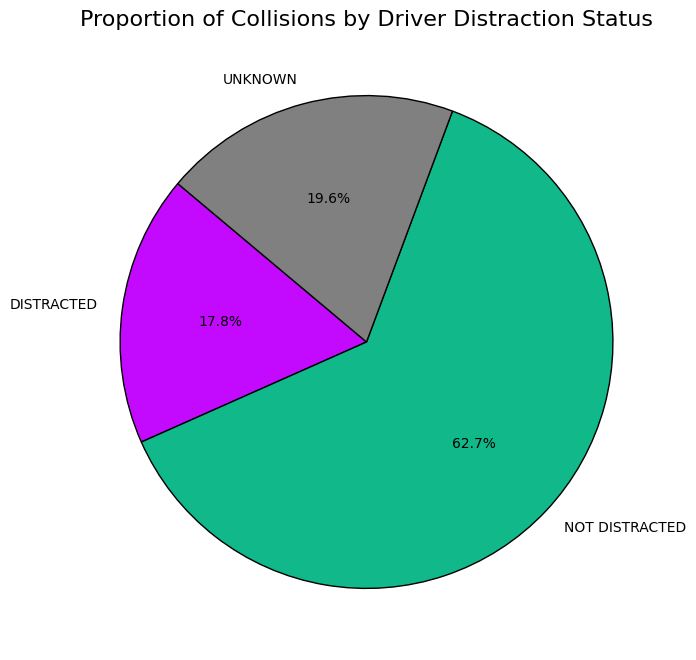

In [28]:
group_counts = severity_by_distracted_drivers["distraction_group"].value_counts()

# Extract counts for each group
distracted_total = group_counts["DISTRACTED"]
not_distracted_total = group_counts["NOT DISTRACTED"]
unknown_total = group_counts["UNKNOWN"]

# Data for pie chart
group_data = [distracted_total, not_distracted_total, unknown_total]
group_labels = ["DISTRACTED", "NOT DISTRACTED", "UNKNOWN"]
group_colors = ["#c30afe", "#10b88a", "gray"]

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    group_data,
    labels=group_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=group_colors,
    wedgeprops={"edgecolor": "black"}
)
plt.title("Proportion of Collisions by Driver Distraction Status", fontsize=16)
plt.show()

#### Hypotheses Testing: Severity by distracted/not distracted drivers
We will use a **two-proportion z-test** to compare the proportions of severe collisions between distracted and not distracted drivers. This test determines if the difference in proportions is statistically significant at $ \alpha = 0.05 \$.

- **Null Hypothesis (H₀):** The proportion of severe collisions in the distracted group is equal to the proportion of severe collisions in the not distracted group.


- **Alternative Hypothesis (H₁):** The proportion of severe collisions in the distracted group is different from the proportion of severe collisions in the not distracted group.

**Significance level: 
a = 0.05**

In [29]:
severity_by_distracted_drivers.groupby("distraction_group")["severity"].agg(["count", "mean"]).reset_index()


distraction_group   count      mean
0        DISTRACTED   33279  0.011389
1    NOT DISTRACTED  117402  0.011099
2           UNKNOWN   36647  0.024095

In [30]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Filter the severe collisions for each group
not_distracted_severe = severity_by_distracted_drivers[
    (severity_by_distracted_drivers["distraction_group"] == "NOT DISTRACTED") &
    (severity_by_distracted_drivers["severity"] == 1)
].shape[0]

distracted_severe = severity_by_distracted_drivers[
    (severity_by_distracted_drivers["distraction_group"] == "DISTRACTED") &
    (severity_by_distracted_drivers["severity"] == 1)
].shape[0]

# Filter total collisions for each group
not_distracted_total = severity_by_distracted_drivers[
    severity_by_distracted_drivers["distraction_group"] == "NOT DISTRACTED"
].shape[0]

distracted_total = severity_by_distracted_drivers[
    severity_by_distracted_drivers["distraction_group"] == "DISTRACTED"
].shape[0]

# Count successes and totals
success_counts = np.array([distracted_severe, not_distracted_severe])
sample_sizes = np.array([distracted_total, not_distracted_total])

# Perform the z-test
z_stat, p_value = proportions_ztest(count=success_counts, nobs=sample_sizes, alternative='two-sided')

# Print the results
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")


Z-Statistic: 0.4444
P-Value: 0.6568


**Test result: Given large p=0.6558, We failed to reject *H0* (severity rate is same for both distracted/not distracted drivers)t**

#### Severity of Injuries

In [31]:
def plot_barchart(data, x_col, y_col, figsize=(10, 6), title="", color="Reds_r", xlabel="", ylabel="", annotate=True):
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=data,
        x=x_col,
        y=y_col,
        palette=color
    )

    if annotate:
        for index, value in enumerate(data[x_col]):
            ax.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.tight_layout()
    plt.show()

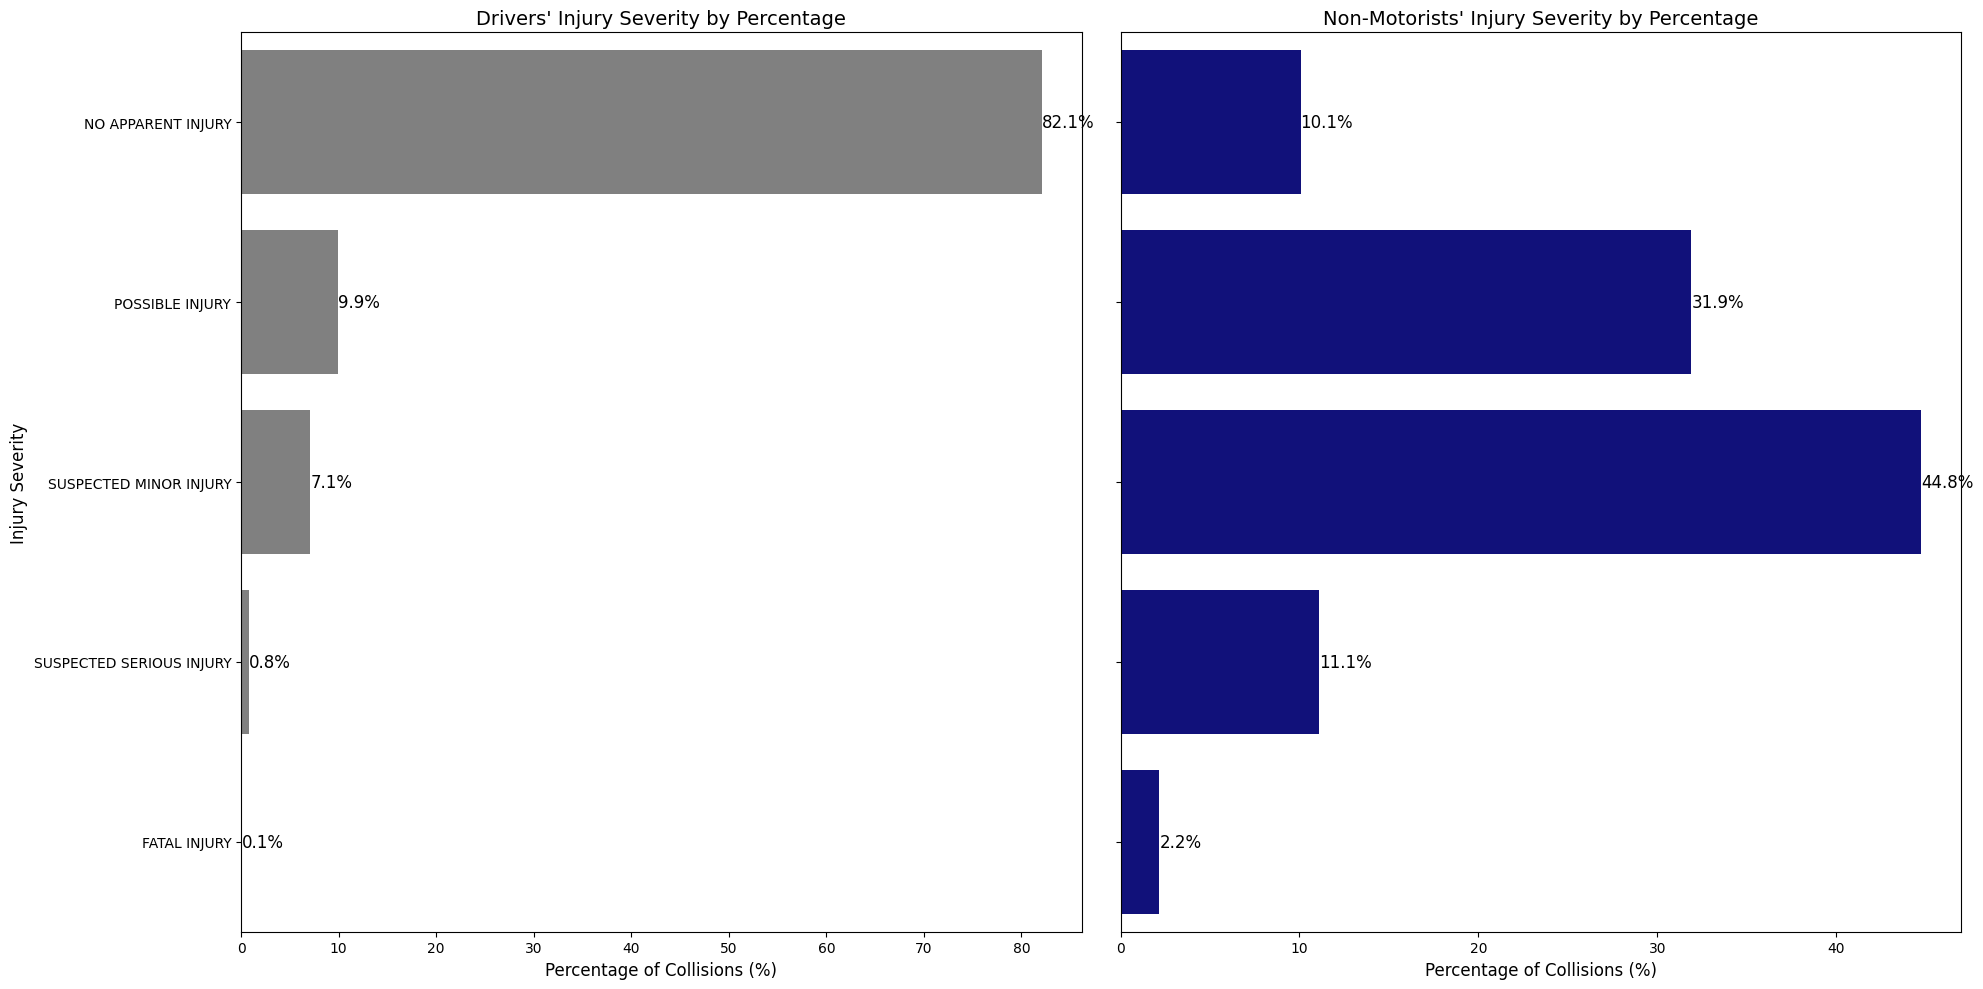

In [32]:

# Calculate value counts and percentages for drivers' injury severity
drivers_injury_severity = drivers_df['injury_severity'].str.upper().value_counts().reset_index()
drivers_injury_severity.columns = ['injury_severity', 'count']
drivers_injury_severity["percentage"] = (drivers_injury_severity["count"] / drivers_injury_severity["count"].sum()) * 100

# Calculate value counts and percentages for non-motorists' injury severity
non_motorist_injury_severity = nonmotorist_df['injury_severity'].str.upper().value_counts().reset_index()
non_motorist_injury_severity.columns = ['injury_severity', 'count']
non_motorist_injury_severity["percentage"] = (
    non_motorist_injury_severity["count"] / non_motorist_injury_severity["count"].sum()
) * 100


# Create subplots with rotated bars
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Plot drivers' injury severity with horizontal bars
sns.barplot(
    data=drivers_injury_severity,
    x="percentage",
    y="injury_severity",
    ax=axes[0],
    color="grey",
    orient='h'  # Horizontal orientation
)
axes[0].set_title("Drivers' Injury Severity by Percentage", fontsize=14)
axes[0].set_xlabel("Percentage of Collisions (%)", fontsize=12)
axes[0].set_ylabel("Injury Severity", fontsize=12)

# Add percentage labels to bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=12)

# Plot non-motorists' injury severity with horizontal bars
sns.barplot(
    data=non_motorist_injury_severity,
    x="percentage",
    y="injury_severity",
    ax=axes[1],
    color="darkblue",
    orient='h'  # Horizontal orientation
)
axes[1].set_title("Non-Motorists' Injury Severity by Percentage", fontsize=14)
axes[1].set_xlabel("Percentage of Collisions (%)", fontsize=12)
axes[1].set_ylabel("")  # No ylabel for the second plot for cleanliness

# Add percentage labels to bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


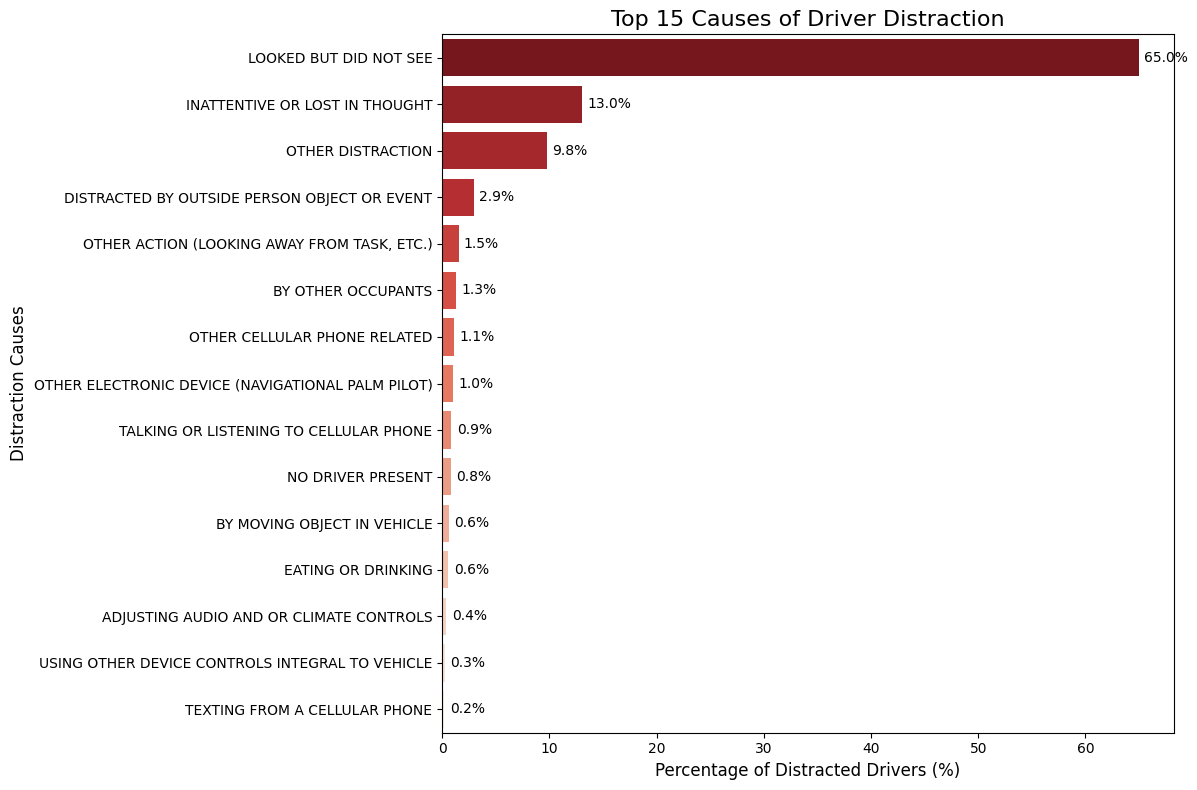

In [33]:
# Filter out "UNKNOWN" and "NOT DISTRACTED"
filtered_distractions = drivers_df[
    ~drivers_df["driver_distracted_by"].isin(["UNKNOWN", "NOT DISTRACTED"])
]

# Get the top 10 most frequent causes of distraction
top_10_distractions = (
    filtered_distractions["driver_distracted_by"]
    .value_counts(normalize=True)  # Normalize to get percentages
    .head(15) * 100  # Convert to percentages
)

top_10_distractions_df = top_10_distractions.reset_index()
top_10_distractions_df.columns = ["Distraction Cause", "Percentage"]

# Plot using the function
plot_barchart(
    data=top_10_distractions_df,
    x_col="Percentage",
    y_col="Distraction Cause",
    figsize=(12, 8),
    title="Top 15 Causes of Driver Distraction",
    color="Reds_r",
    xlabel="Percentage of Distracted Drivers (%)",
    ylabel="Distraction Causes",
    annotate=True
)

#### First Harmful Event in collisions

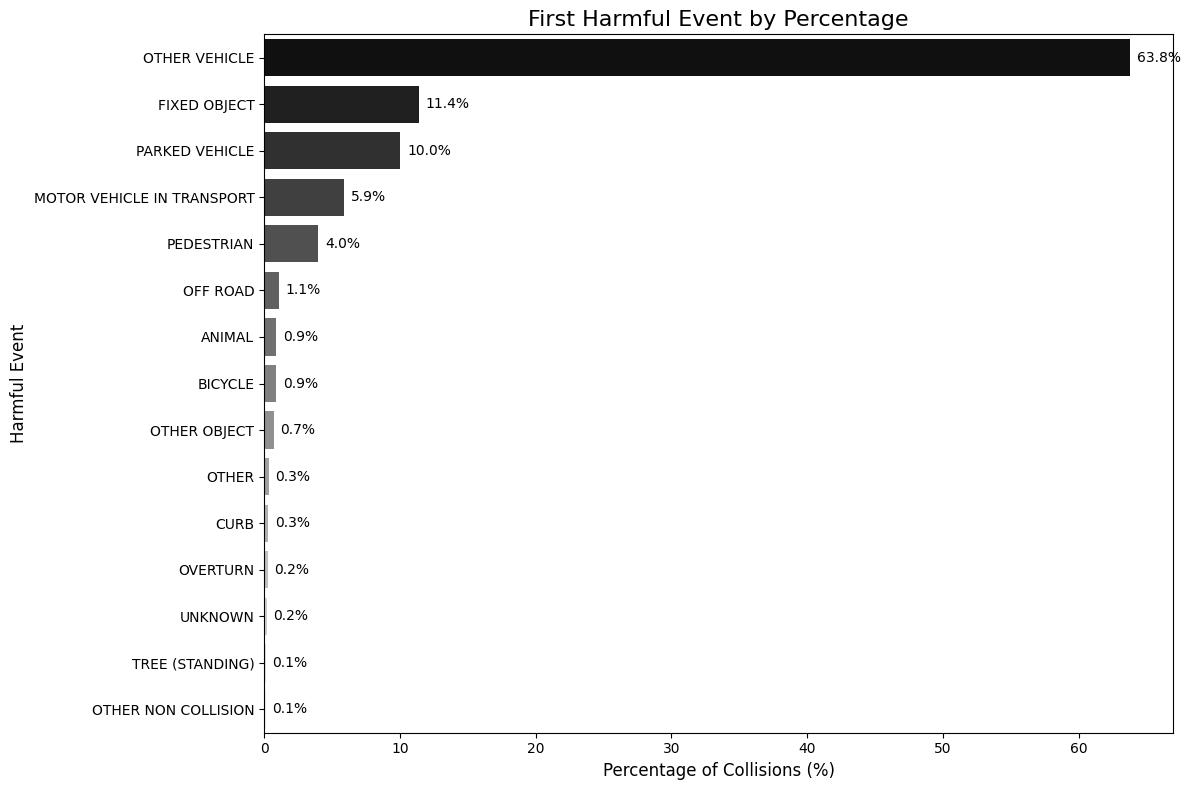

In [34]:
first_harmful_event = incidents_df['first_harmful_event'].str.upper().value_counts().reset_index().head(15)
first_harmful_event["percentage"] = (first_harmful_event["count"] / first_harmful_event["count"].sum()) * 100

# Plot using the function
plot_barchart(
    data=first_harmful_event,
    y_col="first_harmful_event",
    x_col="percentage",
    title="First Harmful Event by Percentage",
    color="grey",
    xlabel="Percentage of Collisions (%)",
    ylabel="Harmful Event",
    figsize=(12, 8)
)

**Will be extended later...**

In [35]:
drivers_df["location"]

0           (38.98765667, -76.987545)
1         (39.03991652, -77.05364898)
2           (38.743373, -77.54699707)
3         (39.14587303, -77.19194047)
4         (39.02517017, -77.07633333)
                     ...             
188085    (39.04477691, -77.11184132)
188086    (39.05637133, -77.08281067)
188087    (39.04490667, -77.02173833)
188088    (39.04143195, -77.16452712)
188089    (39.09117006, -77.07087721)
Name: location, Length: 188090, dtype: object

### Geospatial Analysis

In [77]:
incidents_by_geo_df = conn.sql("""SELECT 
    I.report_number,
    I.crash_datetime,
    CASE 
        WHEN D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
             OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY')
        THEN 1
        ELSE 0
    END AS severity,
    -- Extract latitude and longitude from the location tuple and cast to float
    CAST(SUBSTR(D.location, INSTR(D.location, '(') + 1, INSTR(D.location, ',') - INSTR(D.location, '(') - 1) AS FLOAT) AS latitude,
    CAST(SUBSTR(D.location, INSTR(D.location, ',') + 2, INSTR(D.location, ')') - INSTR(D.location, ',') - 2) AS FLOAT) AS longitude,
    -- Binary flag for no traffic control
    CASE 
        WHEN UPPER(D.traffic_control) = 'NO CONTROLS' THEN 0
        ELSE 1
    END AS traffic_control,
    -- Binary flag for light condition containing 'LIGHT'
    CASE 
        WHEN UPPER(D.light) LIKE '%LIGHT%' THEN 1
        ELSE 0
    END AS light,
    -- Binary flag for pedestrian involvement
    CASE 
        WHEN NM.report_number IS NOT NULL THEN 1
        ELSE 0
    END AS pedestrian_involved,
    CASE 
        WHEN D.driver_distracted_by = 'NOT DISTRACTED' THEN 'NOT DISTRACTED'
        WHEN D.driver_distracted_by = 'UNKNOWN' THEN 'UNKNOWN'        
        ELSE 'DISTRACTED'
    END AS driver_distraction,
    CASE 
        WHEN D.driver_distracted_by = 'NOT DISTRACTED' THEN 'NOT DISTRACTED'
        WHEN D.driver_distracted_by = 'UNKNOWN' THEN 'UNKNOWN'        
        ELSE 'DISTRACTED'
    END AS driver_distraction,
    UPPER(I.first_harmful_event) as first_harmful_event,
    CASE
        WHEN 'ALCOHOL CONTRIBUTED' IN D.driver_substance_abuse THEN 1
        ELSE 0
    END AS is_alcohol_present_driver

    
FROM incidents I
LEFT JOIN drivers D 
    ON I.report_number = D.report_number
LEFT JOIN non_motorist NM 
    ON I.report_number = NM.report_number
WHERE D.location IS NOT NULL
ORDER BY I.crash_datetime;



""").fetchdf()


incidents_by_geo_df_nonsev = incidents_by_geo_df[incidents_by_geo_df["severity"] == 0]
incidents_by_geo_df_sev = incidents_by_geo_df[incidents_by_geo_df["severity"] == 1]


### Global Spatial Autocorrelation

#### Geodata Preprocessing

**Census summary of County**: https://data.census.gov/profile/Montgomery_County,_Maryland?g=050XX00US24031

**Convert incidents df to GeoDF**

In [78]:
from pysal.explore import esda
from pysal.lib import weights
import geopandas as gpd
from shapely.geometry import Point
from pysal.viz import splot
from splot.esda import plot_moran, lisa_cluster, plot_local_autocorrelation, moran_scatterplot
import contextily


#convert our incidents by severity to geodf
crash_gdf = gpd.GeoDataFrame(
    incidents_by_geo_df,  # Replace with your crash dataset
    geometry=[Point(xy) for xy in zip(incidents_by_geo_df.longitude, incidents_by_geo_df.latitude)],
    crs="EPSG:4326",
)

**Maryland Census Tracts 2024**: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=Census+Tracts

**Read census tracts**

In [79]:
# Read polygons of census tracts
maryland_tracts = gpd.read_file("./census_tracts/tl_2024_24_tract.shp")

# Ensure the CRS is EPSG:4326 (WGS 84 - Latitude/Longitude)
if maryland_tracts.crs != "EPSG:4326":
    maryland_tracts = maryland_tracts.to_crs("EPSG:4326")

# Filter for Montgomery County using COUNTYFP (FIPS code for Montgomery County is 031)
montgomery_tracts = maryland_tracts[maryland_tracts["COUNTYFP"] == "031"]

In [80]:
montgomery_tracts.shape

(232, 14)

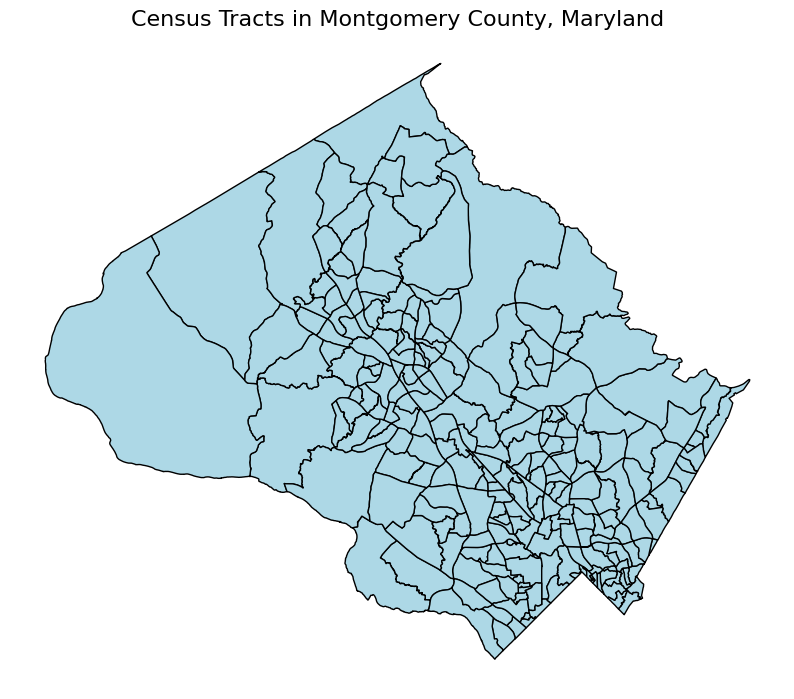

In [81]:
montgomery_tracts.plot(edgecolor="black", color="lightblue", figsize=(10, 10))
plt.title("Census Tracts in Montgomery County, Maryland", fontsize=16)
plt.axis("off")
plt.show()

In [82]:
montgomery_tracts.head(3)

STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ     NAME  \
73      24      031  705601  24031705601  1400000US24031705601  7056.01   
74      24      031  705501  24031705501  1400000US24031705501  7055.01   
75      24      031  705701  24031705701  1400000US24031705701  7057.01   

                NAMELSAD  MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT  \
73  Census Tract 7056.01  G5020        S  1179882    5940  +38.9566642   
74  Census Tract 7055.01  G5020        S   496065       0  +38.9607393   
75  Census Tract 7057.01  G5020        S  1918394       0  +38.9658091   

        INTPTLON                                           geometry  
73  -077.1006777  POLYGON ((-77.10876 38.95786, -77.10833 38.958...  
74  -077.0902928  POLYGON ((-77.09686 38.9603, -77.09617 38.9614...  
75  -077.1157240  POLYGON ((-77.133 38.96948, -77.13198 38.96971...

**Join incidents with census tracts**

In [83]:
# Perform spatial join: associate each crash with a census tract
crashes_with_tracts_gdf = gpd.sjoin(crash_gdf, montgomery_tracts, how="left")


In [84]:
crashes_with_tracts_gdf.head()

report_number       crash_datetime  severity   latitude  longitude  \
0   MCP11520005  2015-01-01 00:30:00         0  39.021999 -77.102676   
1   MCP11520005  2015-01-01 00:30:00         0  39.021999 -77.102676   
2   MCP2686000D  2015-01-01 01:10:00         0  39.196609 -77.265549   
3   MCP2686000D  2015-01-01 01:10:00         0  39.196609 -77.265549   
4   MCP2783000G  2015-01-01 01:14:00         0  39.096218 -77.109802   

   traffic_control  light  pedestrian_involved driver_distraction  \
0                1      1                    0         DISTRACTED   
1                1      1                    0     NOT DISTRACTED   
2                1      1                    0     NOT DISTRACTED   
3                1      1                    0     NOT DISTRACTED   
4                1      1                    0         DISTRACTED   

  driver_distraction_1  ...        GEOID               GEOIDFQ     NAME  \
0           DISTRACTED  ...  24031704401  1400000US24031704401  7044.01   
1       NOT DISTRACTED  ...  24031704401  1400000US24031704401  7044.01   
2       NOT DISTRACTED  ...  24031700309  1400000US24031700309  7003.09   
3       NOT DISTRACTED  ...  24031700309  1400000US24031700309  7003.09   
4           DISTRACTED  ...  24031701303  1400000US24031701303  7013.03   

               NAMELSAD  MTFCC FUNCSTAT      ALAND    AWATER     INTPTLAT  \
0  Census Tract 7044.01  G5020        S  2263541.0    1986.0  +39.0218818   
1  Census Tract 7044.01  G5020        S  2263541.0    1986.0  +39.0218818   
2  Census Tract 7003.09  G5020        S  2319420.0   11099.0  +39.1881087   
3  Census Tract 7003.09  G5020        S  2319420.0   11099.0  +39.1881087   
4  Census Tract 7013.03  G5020        S  4148547.0  131882.0  +39.1074390   

       INTPTLON  
0  -077.1147298  
1  -077.1147298  
2  -077.2703189  
3  -077.2703189  
4  -077.0989671  

[5 rows x 27 columns]

**Count collisions in each tract**

In [85]:
# Count total and severe crashes by census tract
tract_crash_counts = crashes_with_tracts_gdf.groupby("GEOID").agg(
    total_crashes=("severity", "count"),
    severe_crashes=("severity", "sum"),
    light_crashes=("light", "sum"),
    trafic_control_crashes=("traffic_control", "sum"),
    pedestrian_crashes=("pedestrian_involved", "sum")
).reset_index()


In [86]:
montgomery_tracts_with_counts = montgomery_tracts.merge(tract_crash_counts, on="GEOID", how="left")
montgomery_tracts_with_counts = montgomery_tracts_with_counts.fillna(0)


In [87]:
montgomery_tracts_with_counts.head(3)

STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ     NAME  \
0      24      031  705601  24031705601  1400000US24031705601  7056.01   
1      24      031  705501  24031705501  1400000US24031705501  7055.01   
2      24      031  705701  24031705701  1400000US24031705701  7057.01   

               NAMELSAD  MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT  \
0  Census Tract 7056.01  G5020        S  1179882    5940  +38.9566642   
1  Census Tract 7055.01  G5020        S   496065       0  +38.9607393   
2  Census Tract 7057.01  G5020        S  1918394       0  +38.9658091   

       INTPTLON                                           geometry  \
0  -077.1006777  POLYGON ((-77.10876 38.95786, -77.10833 38.958...   
1  -077.0902928  POLYGON ((-77.09686 38.9603, -77.09617 38.9614...   
2  -077.1157240  POLYGON ((-77.133 38.96948, -77.13198 38.96971...   

   total_crashes  severe_crashes  light_crashes  trafic_control_crashes  \
0            286               2            278                     143   
1            417               6            387                     255   
2            421               7            402                     248   

   pedestrian_crashes  
0                   3  
1                  23  
2                  20

**Visualize collision counts**

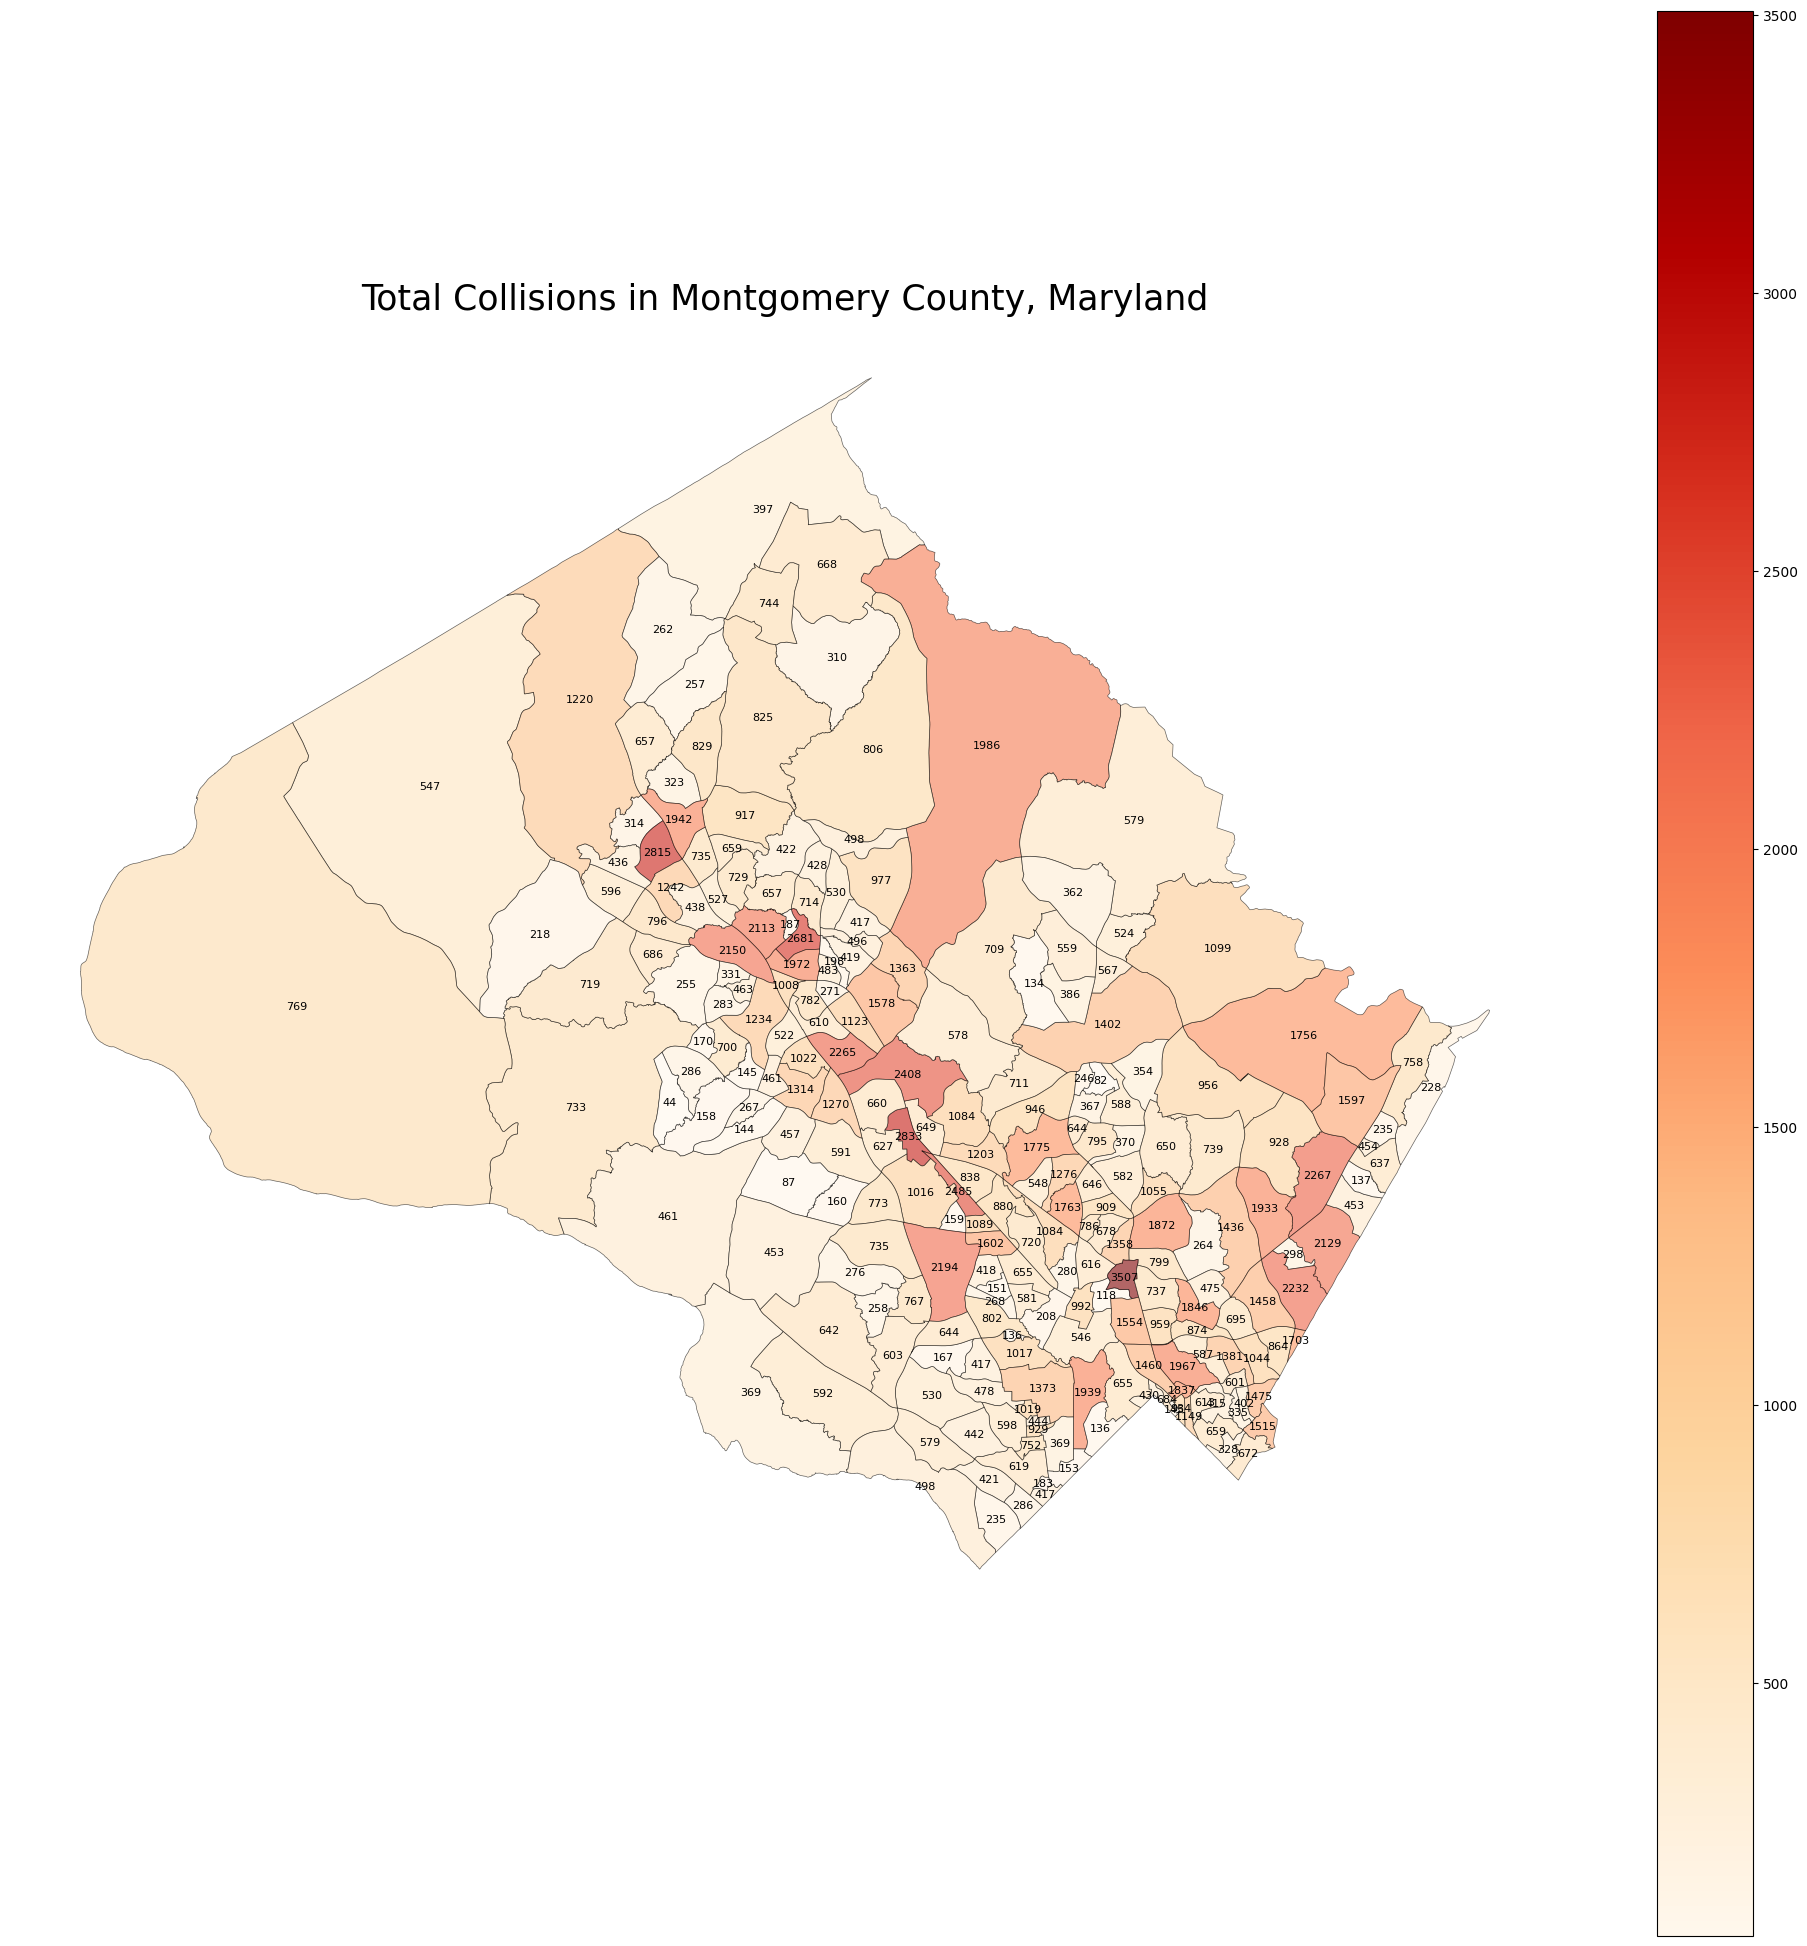

In [88]:
fig, ax = plt.subplots(figsize=(25, 25))

# Plot the Montgomery County tracts with total crashes
montgomery_tracts_with_counts.plot(
    column="total_crashes",  
    cmap="OrRd",  # Color map
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.6,
    ax=ax,
)

# Add crash counts as labels
for idx, row in montgomery_tracts_with_counts.iterrows():
    # Display text in the center of each polygon
    if row['total_crashes'] > 0:  # Only display if there are crashes
        ax.text(
            row.geometry.centroid.x, 
            row.geometry.centroid.y, 
            int(row['total_crashes']),  # Display as integer
            fontsize=8, 
            color="black",
            ha="center", 
            va="center"
        )

# Remove the scale bar by disabling it explicitly
ax.set_title("Total Collisions in Montgomery County, Maryland", fontsize=25)
ax.axis("off")

plt.show()


**Mongtomery Planning, Maryland,  US**

reference: https://montgomeryplanning.org/planning/communities/

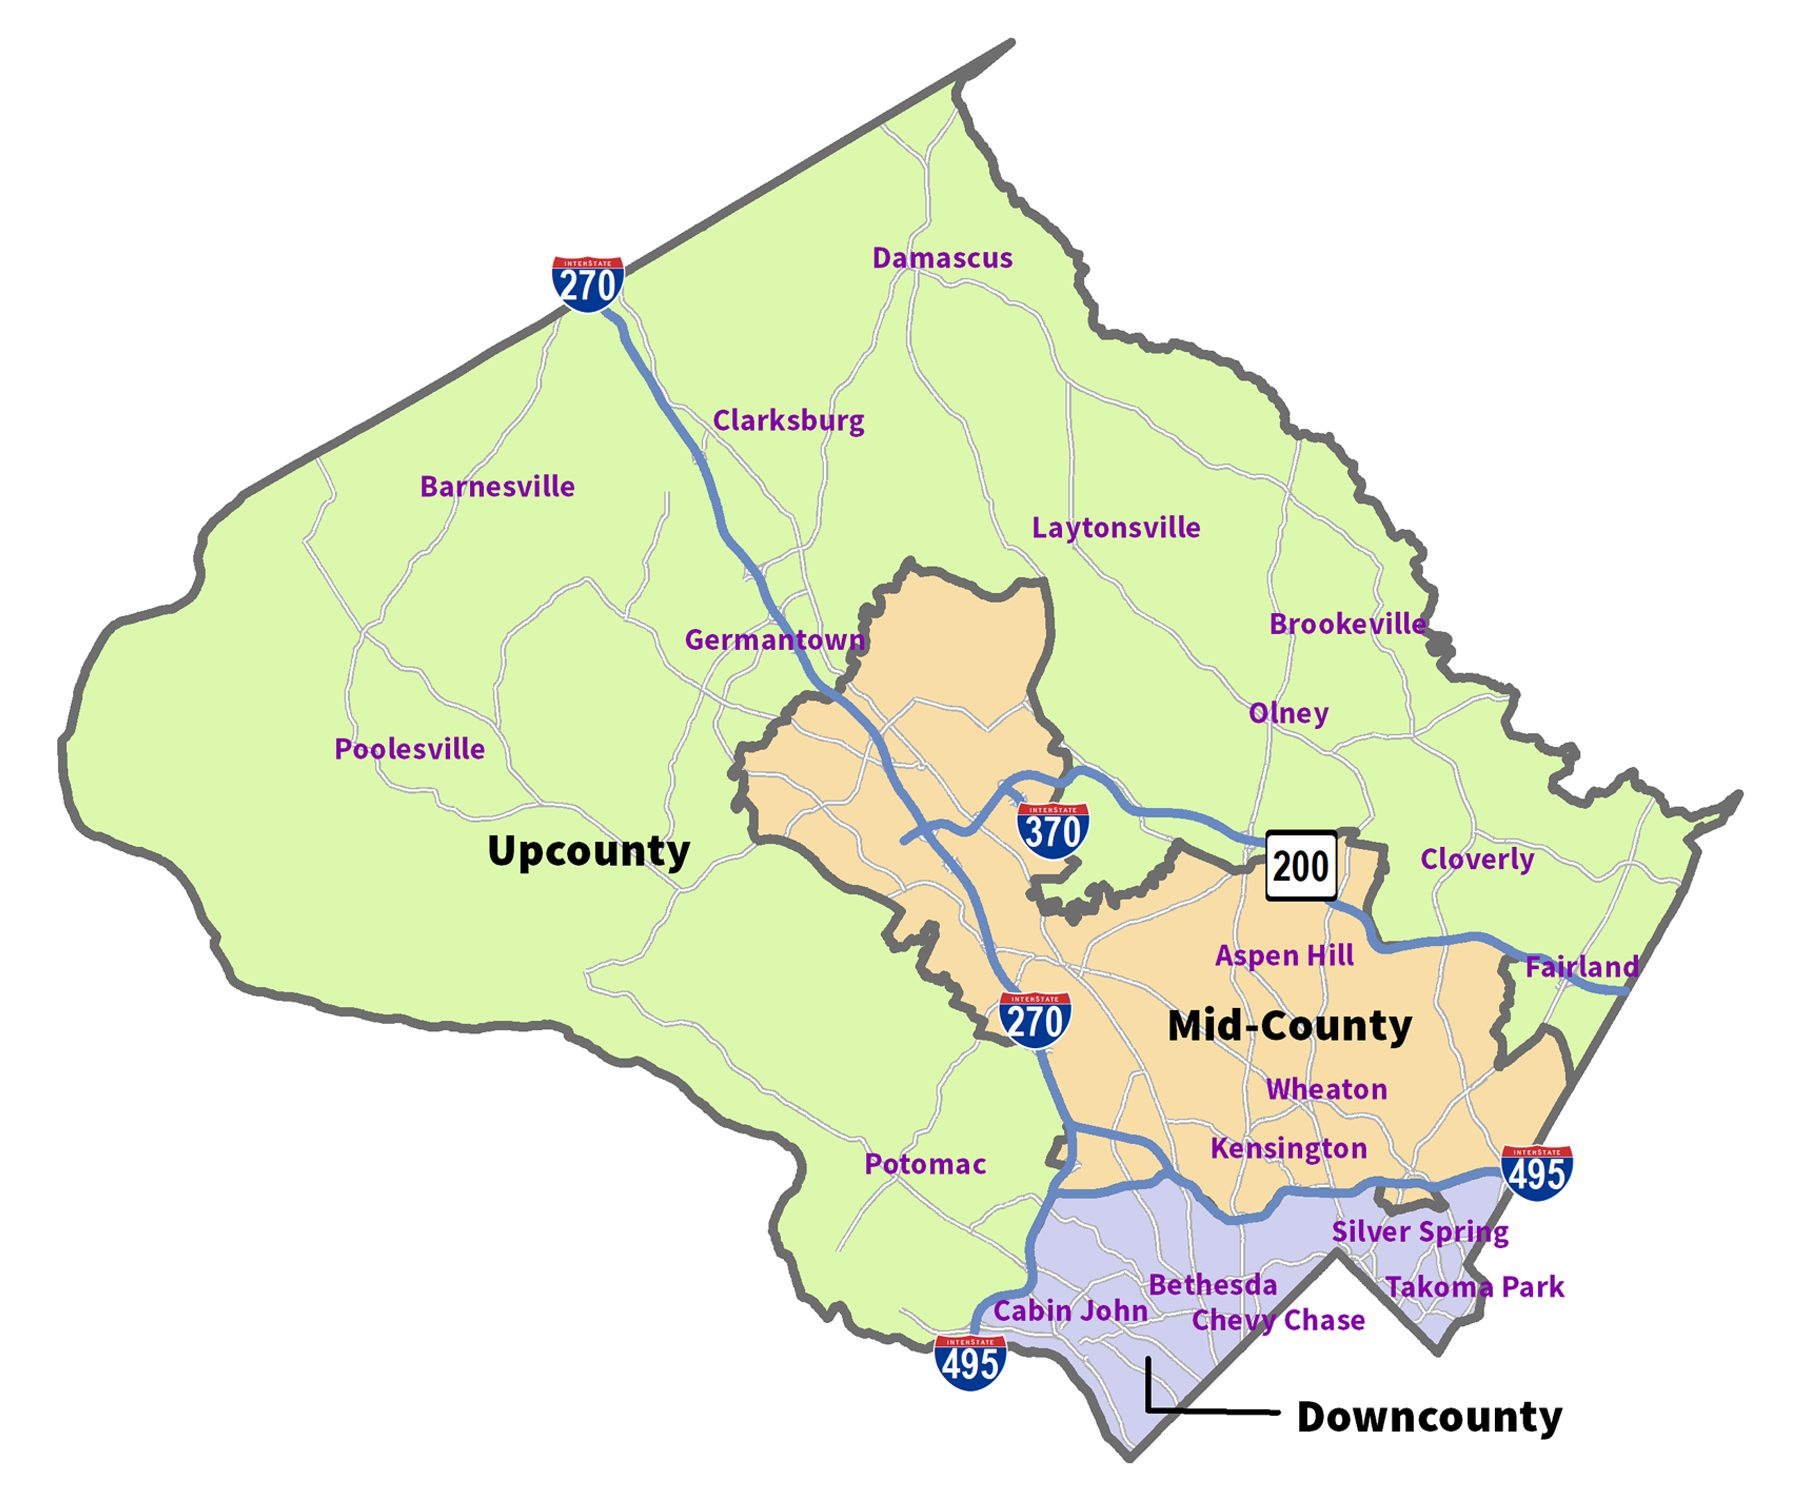

#### Test for Spatial Randomness in Incidents

**Hypotheses for Spatial Randomness**

- **Null Hypothesis (H₀):** The spatial distribution of the variable (e.g., total crashes) follows a random pattern. There is no spatial autocorrelation present.

- **Alternative Hypothesis (H₁):** The spatial distribution of the variable does not follow a random pattern.

**Significance level:
$\alpha = 0.01$**

**Moran's I**: measure of spatial autocorrelation.Spatial autocorrelation is characterized by a correlation in a signal among nearby locations in space.


In [89]:
#KNN weights 

NEIGHBORS = 20

w = weights.KNN.from_dataframe(montgomery_tracts_with_counts, k=NEIGHBORS)
w.transform = "R"  # Row-standardize the weights

In [90]:
#example of neighors set
w.neighbors[0]

[np.int64(1),
 np.int64(167),
 np.int64(3),
 np.int64(166),
 np.int64(2),
 np.int64(158),
 np.int64(217),
 np.int64(169),
 np.int64(218),
 np.int64(213),
 np.int64(161),
 np.int64(224),
 np.int64(157),
 np.int64(214),
 np.int64(206),
 np.int64(216),
 np.int64(8),
 np.int64(223),
 np.int64(215),
 np.int64(205)]

In [91]:
#weights for neigbour
w.weights[0]

[0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05]

In [92]:
# Variable to analyze (total crashes)
y = montgomery_tracts_with_counts["total_crashes"].values

# Compute Moran's I
moran = esda.moran.Moran(y, w)


# Output results
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_norm}")

Moran's I: 0.08087357764927477
P-value: 4.516199068508198e-06


**Results**

- **Moran's I**: **0.08**  
- **P-value**: **4.516e-06**, indicating significant spatial autocorrelation.  
- **Interpretation**: Crash counts are not randomly distributed; areas with similar values (high or low) tend to cluster.

#### LISA: Number of crashes

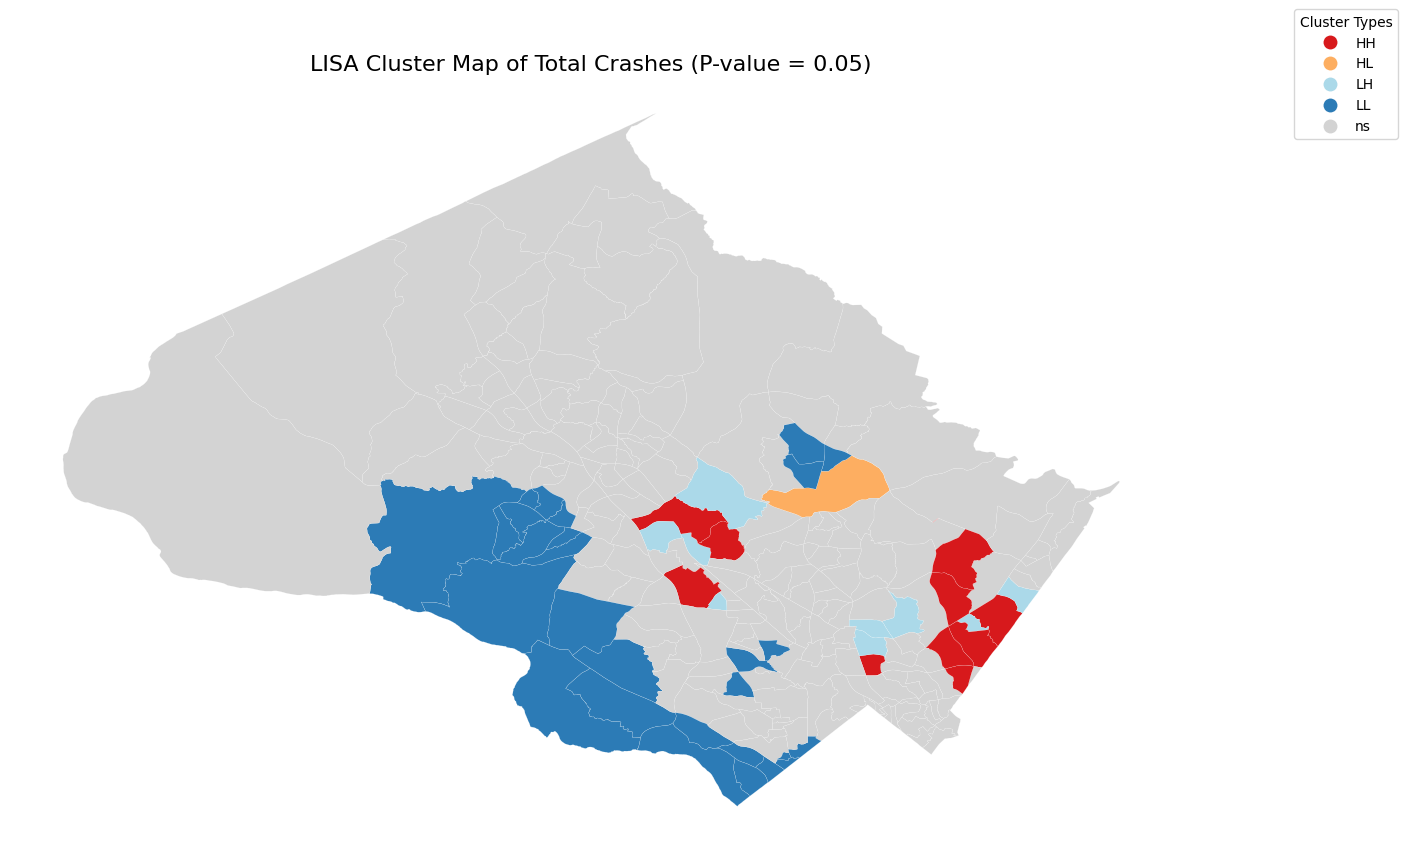

In [120]:
#KNN weights matrix 
NEIGHBORS = 10

w = weights.KNN.from_dataframe(montgomery_tracts_with_counts, k=NEIGHBORS)
w.transform = "R"  # Row-standardize the weights


lisa = esda.Moran_Local(montgomery_tracts_with_counts["total_crashes"],
                        w=w,
                        seed=123,
                        )


montgomery_tracts_with_counts["total_crashes_cluster"] = lisa.q # Cluster classification: 1=HH, 2=LL, 3=LH, 4=HL
montgomery_tracts_with_counts["total_crashes_lisa_pvalue"] = lisa.p_sim #pseudo pvalue
montgomery_tracts_with_counts["total_crashes_local_moran_i"] = lisa.Is # Local Moran's I values

# Plot LISA cluster with a title and modified legend using the same GeoDataFrame (gdf)
fig, ax = plt.subplots(figsize=(15, 15))

fig, ax = lisa_cluster(
    lisa,  # Local Moran's I results
    montgomery_tracts_with_counts,   
    p=0.05,  # Significance threshold
    ax=ax,  # Matplotlib axes
    legend=True,  # Enable legend
    legend_kwds={'loc': 'upper right', 'bbox_to_anchor': (1.2, 1.1), 'title': 'Cluster Types'}
)

# Add a custom title
ax.set_title("LISA Cluster Map of Total Crashes (P-value = 0.05)", fontsize=16)

# Display the plot
plt.show()

In [133]:
hh_total_crashes_tracts_df = montgomery_tracts_with_counts[
    (montgomery_tracts_with_counts["total_crashes_cluster"] == 1) & 
    (montgomery_tracts_with_counts["total_crashes_lisa_pvalue"] <= 0.05)
]

hh_total_crashes_tracts_df[["TRACTCE", "GEOID", "total_crashes_local_moran_i", "total_crashes_lisa_pvalue", "total_crashes"]].head()

TRACTCE        GEOID  total_crashes_local_moran_i  \
20   701211  24031701211                     1.982356   
60   701415  24031701415                     0.111890   
77   700903  24031700903                     0.414987   
87   701001  24031701001                     0.240233   
117  701425  24031701425                     1.244554   

     total_crashes_lisa_pvalue  total_crashes  
20                       0.009           2408  
60                       0.046            928  
77                       0.006           1084  
87                       0.019           1016  
117                      0.046           2129

#### LISA: Number of severe crashes

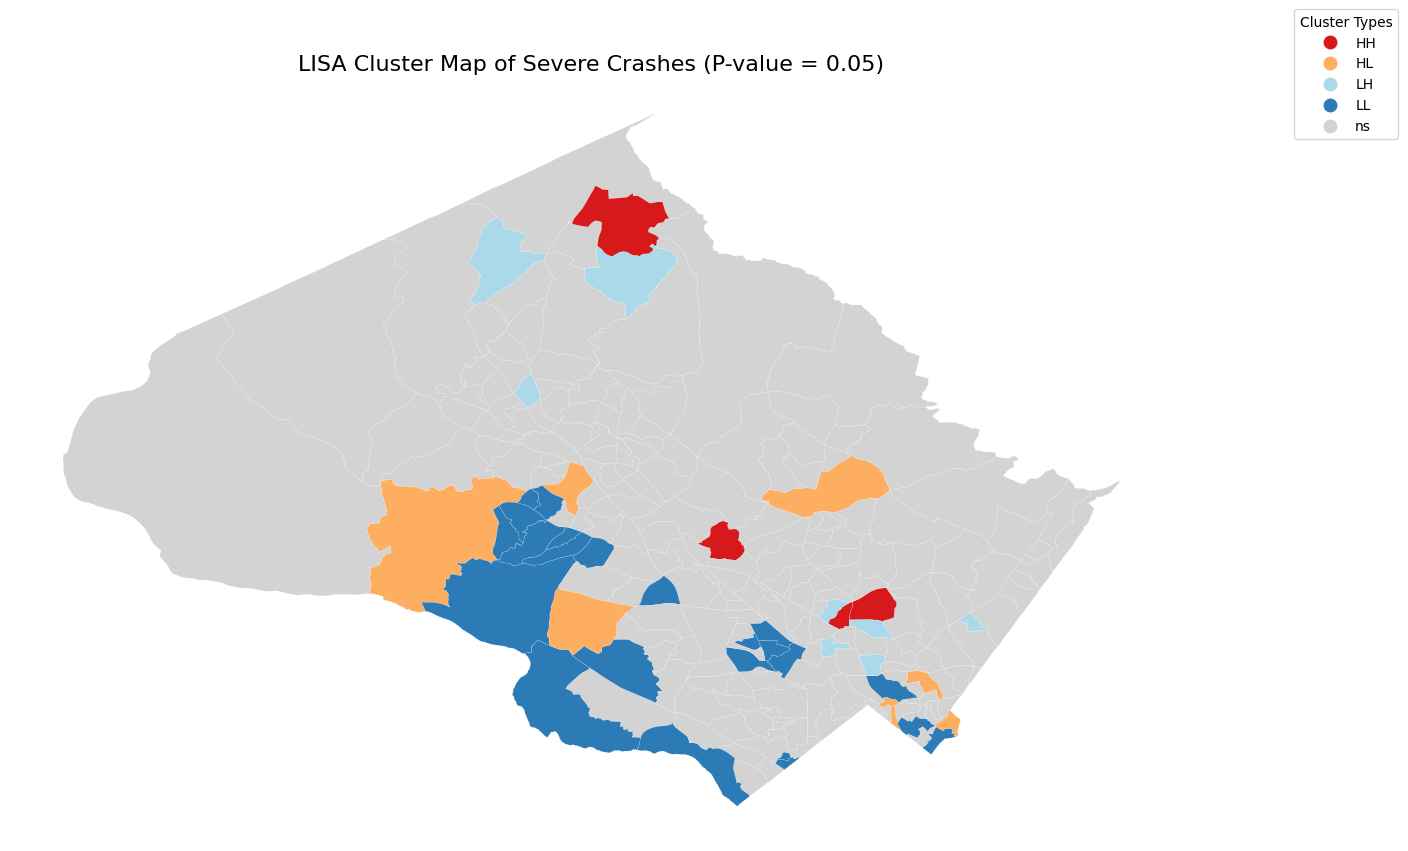

In [134]:
#KNN weights matrix 
NEIGHBORS = 10

w = weights.KNN.from_dataframe(montgomery_tracts_with_counts, k=NEIGHBORS)
w.transform = "R"  # Row-standardize the weights


lisa = esda.Moran_Local(montgomery_tracts_with_counts["severe_crashes"],
                        w=w,
                        seed=123,
                        )

montgomery_tracts_with_counts["severe_crashes_cluster"] = lisa.q # Cluster classification: 1=HH, 2=LL, 3=LH, 4=HL
montgomery_tracts_with_counts["severe_crashes_lisa_pvalue"] = lisa.p_sim #pseudo pvalue
montgomery_tracts_with_counts["severe_crashes_local_moran_i"] = lisa.Is # Local Moran's I values

# Plot LISA cluster with a title and modified legend using the same GeoDataFrame (gdf)
fig, ax = plt.subplots(figsize=(15, 15))

fig, ax = lisa_cluster(
    lisa,  # Local Moran's I results
    montgomery_tracts_with_counts,   
    p=0.05,  # Significance threshold
    ax=ax,  # Matplotlib axes
    legend=True,  # Enable legend
    legend_kwds={'loc': 'upper right', 'bbox_to_anchor': (1.2, 1.1), 'title': 'Cluster Types'}
)

# Add a custom title
ax.set_title("LISA Cluster Map of Severe Crashes (P-value = 0.05)", fontsize=16)

# Display the plot
plt.show()

In [136]:
hh_severe_crashes_tracts_df = montgomery_tracts_with_counts[
    (montgomery_tracts_with_counts["severe_crashes_cluster"] == 1) & 
    (montgomery_tracts_with_counts["severe_crashes_lisa_pvalue"] <= 0.05)
]

hh_severe_crashes_tracts_df[["TRACTCE", "GEOID", "severe_crashes_local_moran_i", "severe_crashes_lisa_pvalue", "total_crashes","severe_crashes"]].head()

TRACTCE        GEOID  severe_crashes_local_moran_i  \
35   703702  24031703702                      0.638826   
71   703207  24031703207                      0.818184   
77   700903  24031700903                      0.428984   
188  700208  24031700208                      0.434318   

     severe_crashes_lisa_pvalue  total_crashes  severe_crashes  
35                        0.028           1358              19  
71                        0.033           1872              22  
77                        0.042           1084              17  
188                       0.005            668              15

#### LISA: Rates of Severe Collisions



In [110]:
#Apply Laplacian Smoothing to avoid Zero Probability

#estimate  rate of severity
montgomery_tracts_with_counts["severity_rate"] = ((montgomery_tracts_with_counts["severe_crashes"] + 1)/
                                                  (montgomery_tracts_with_counts["total_crashes"] + 2) )




#estimate std of rate of severity
montgomery_tracts_with_counts["severity_rate_std"] = (
    (1 - montgomery_tracts_with_counts["severity_rate"]) * montgomery_tracts_with_counts["severity_rate"] 
    / montgomery_tracts_with_counts["total_crashes"]
) ** 0.5




###### Empirical Bayes Index (EBI)

reference: https://www.youtube.com/watch?v=yMcuYRJo1CM&list=PLzREt6r1Nenkr2vtYgbP4hs44HO_s_qEO&index=6

The Empirical Bayes Index (EBI) is calculated as:

$$
EBI = \frac{\text{rate}_i - \text{global\_rate}}{\text{std}_i}
$$

**Components:**

1. **Severity Rate ($\text{rate}_i$)**:
   - With Laplacian smoothing:
   $$
   \text{rate}_i = \frac{\text{severe\_crashes}_i + \alpha}{\text{total\_crashes}_i + 2\alpha}
   $$

2. **Global Rate ($\text{global\_rate}$)**:
   - The mean severity rate across all regions:
   $$
   \text{global\_rate} = \frac{\sum \text{severe\_crashes}_i}{\sum \text{total\_crashes}_i}
   $$

3. **Standard Deviation ($\text{std}_i$)**:
   - With Laplacian smoothing:
   $$
   \text{std}_i = \sqrt{\frac{\text{rate}_i \cdot (1 - \text{rate}_i)}{\text{total\_crashes}_i + 2\alpha}}
   $$

**Notes:**
- $\alpha$ is the smoothing parameter, often set to $1$ to prevent zero counts from skewing the results.
- Larger values of $EBI$ indicate regions where the severity rate is significantly higher than the global average, while smaller (negative) values indicate the opposite.


In [111]:
#global statistic
total_tracts = len(montgomery_tracts_with_counts)
total_collisions = montgomery_tracts_with_counts["total_crashes"].sum()
total_severe_collisions = montgomery_tracts_with_counts["severe_crashes"].sum()


#global severity rate in Mongtomery
global_severity_rate = (total_severe_collisions + 1) / (total_collisions + 2)

In [112]:
float(global_severity_rate)

0.013622178909586648

In [113]:

#compute EBI for each tract
montgomery_tracts_with_counts["EBI_severity"] = (
    (montgomery_tracts_with_counts["severity_rate"] - global_severity_rate) / montgomery_tracts_with_counts["severity_rate_std"]
)


# Compute the mean and standard deviation of EBI
ebi_mean = montgomery_tracts_with_counts["EBI_severity"].mean()
ebi_std = montgomery_tracts_with_counts["EBI_severity"].std()

# Standardize EBI
montgomery_tracts_with_counts["EBI_severity_standardized"] = (
    (montgomery_tracts_with_counts["EBI_severity"] - ebi_mean) / ebi_std
)


##### LISA (Local Indicators of Spatial Autocorrelation)

In [114]:
#KNN weights matrix 

NEIGHBORS = 10

w = weights.KNN.from_dataframe(montgomery_tracts_with_counts, k=NEIGHBORS)
w.transform = "R"  # Row-standardize the weights


lisa = esda.Moran_Local(montgomery_tracts_with_counts["EBI_severity_standardized"],
                        w=w,
                        seed=123,
                        )


In [115]:
montgomery_tracts_with_counts["lisa_pvalue"] = lisa.p_sim #pseudo pvalue
montgomery_tracts_with_counts["local_moran_i"] = lisa.Is # Local Moran's I values

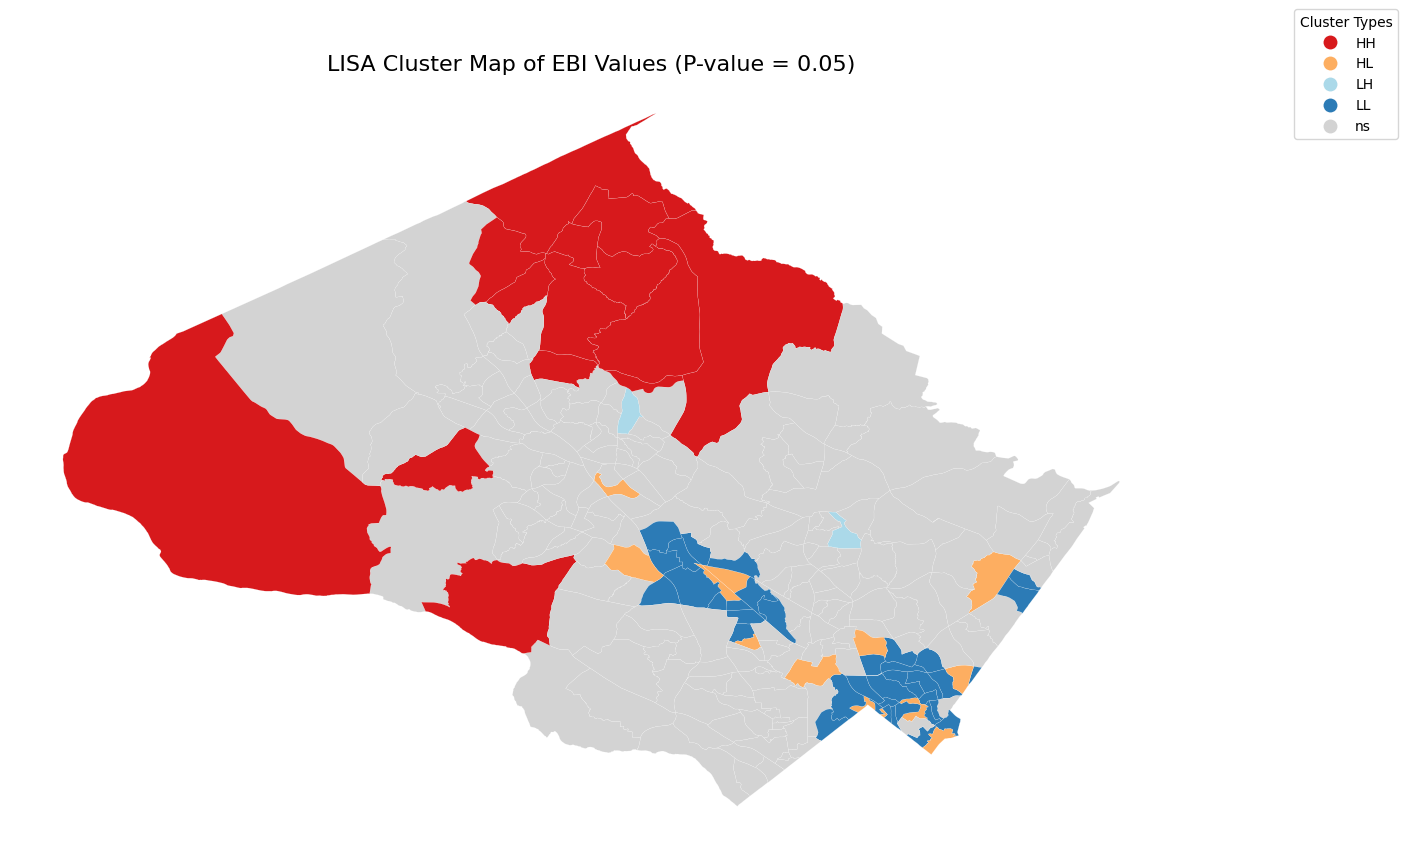

In [116]:
# Plot LISA cluster with a title and modified legend using the same GeoDataFrame (gdf)
fig, ax = plt.subplots(figsize=(15, 15))

fig, ax = lisa_cluster(
    lisa,  # Local Moran's I results
    montgomery_tracts_with_counts,   
    p=0.05,  # Significance threshold
    ax=ax,  # Matplotlib axes
    legend=True,  # Enable legend
    legend_kwds={'loc': 'upper right', 'bbox_to_anchor': (1.2, 1.1), 'title': 'Cluster Types'}
)

# Add a custom title
ax.set_title("LISA Cluster Map of EBI Values (P-value = 0.05)", fontsize=16)

# Display the plot
plt.show()

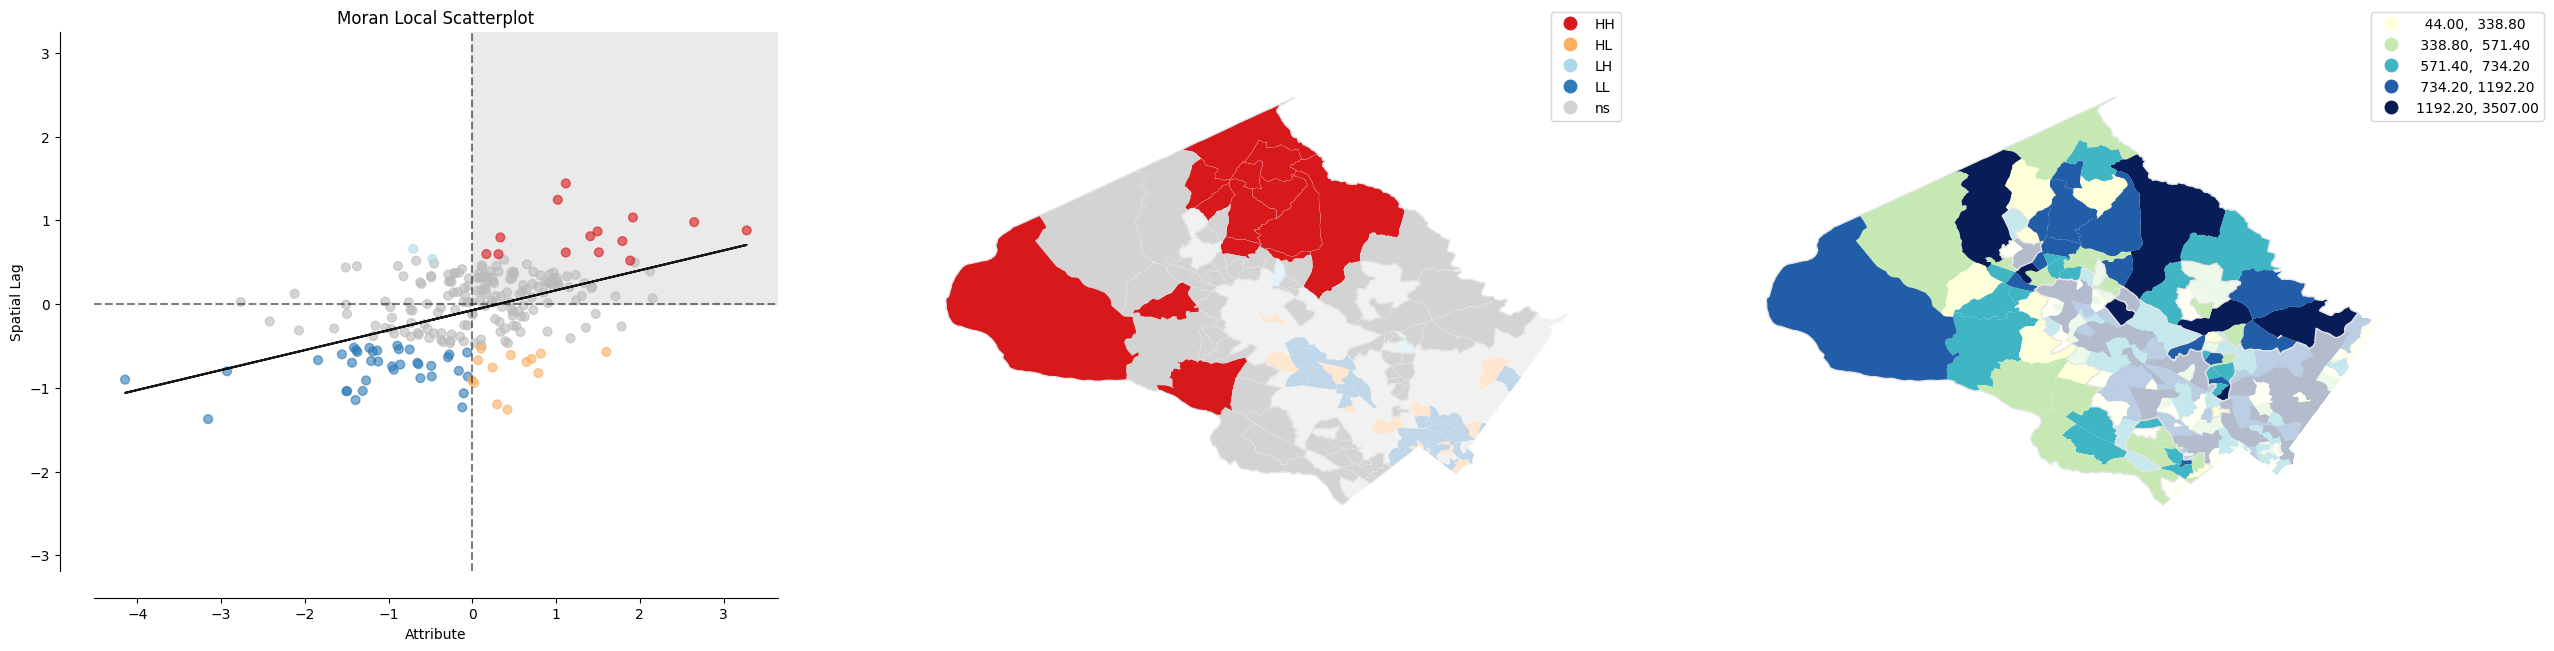

In [117]:
plot_local_autocorrelation(lisa,
                           montgomery_tracts_with_counts,
                           'total_crashes', quadrant=1, p=0.05,
                          figsize=(30, 7))
plt.show()


#### Hotspots of Crashes (More Granular, at Level of Individual collisions)

In [142]:
from shapely.geometry import MultiPolygon

def extract_largest_polygon(geometry):
    if isinstance(geometry, MultiPolygon):
        return max(geometry.geoms, key=lambda g: g.area)  # Extract largest Polygon
    return geometry

montgomery_tracts["geometry"] = montgomery_tracts["geometry"].apply(extract_largest_polygon)


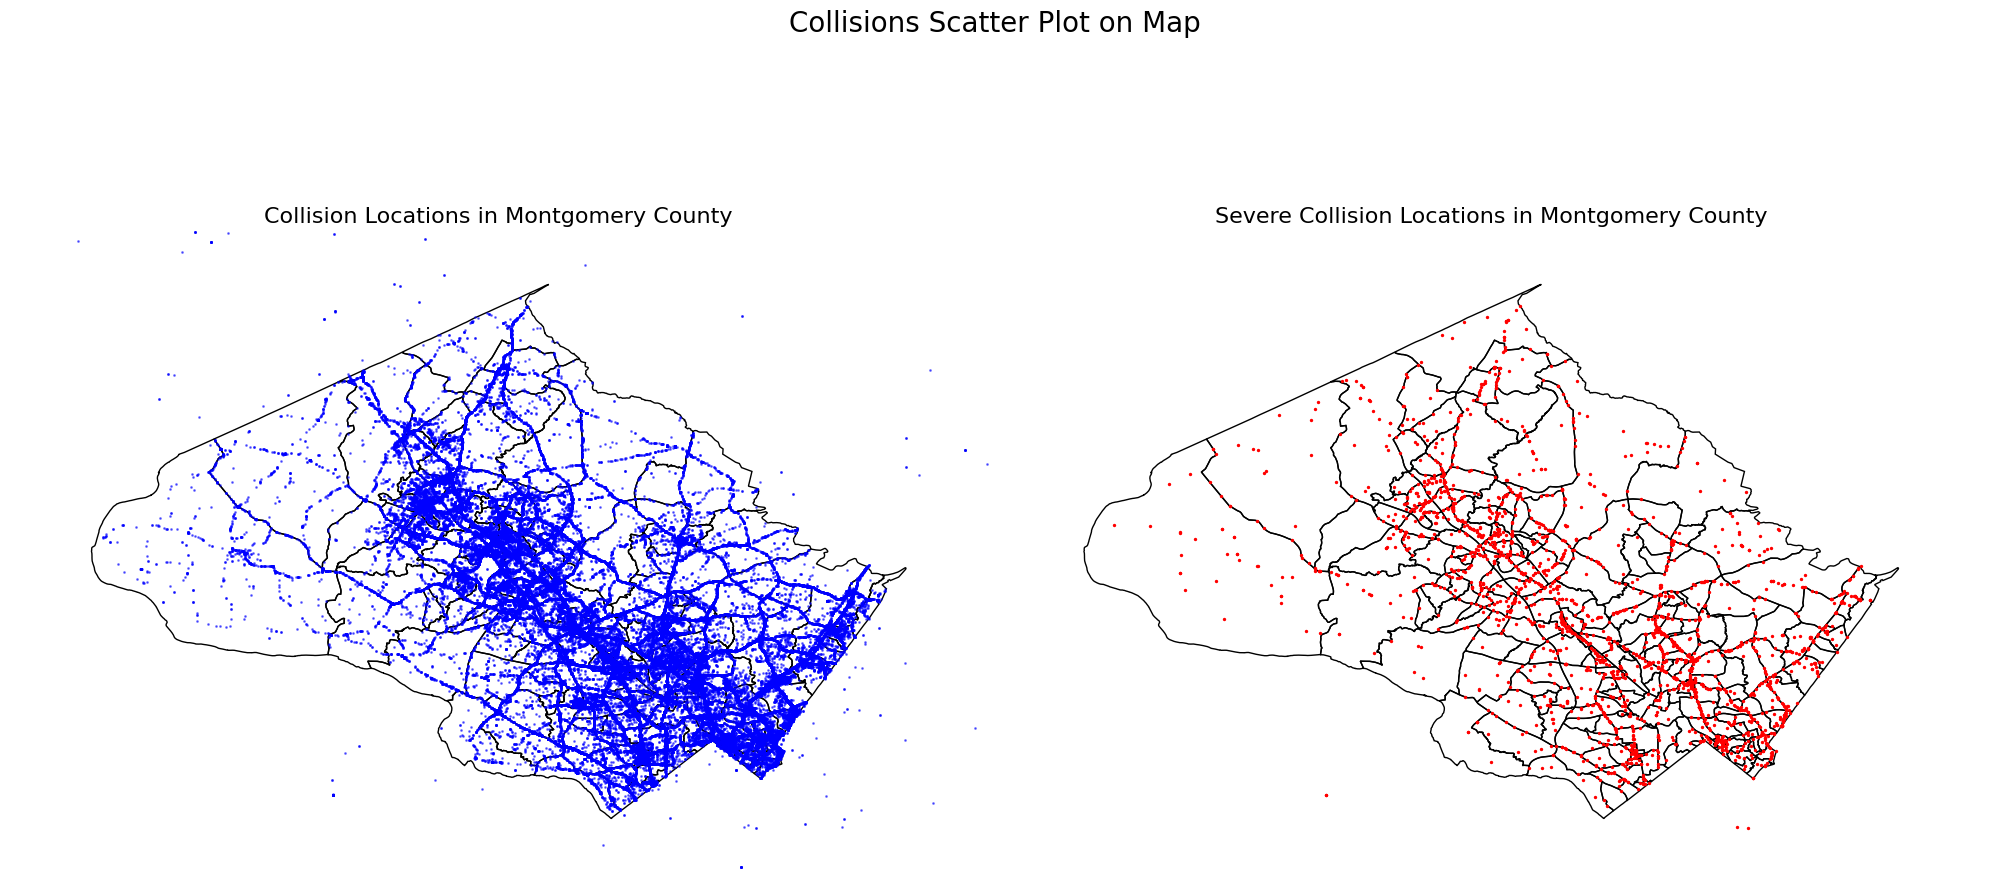

In [143]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

# Scatter Plot 1: All collisions
crashes_with_tracts_gdf.plot(
    ax=axes[0],
    column=None,
    color="blue",
    alpha=0.5,
    markersize=1,
    legend=False
)
geoplot.polyplot(montgomery_tracts, ax=axes[0], edgecolor="black")
axes[0].set_title("Collision Locations in Montgomery County", fontsize=16)

# Scatter Plot 2: Severe collisions
crashes_with_tracts_gdf[crashes_with_tracts_gdf["severity"] == 1].plot(
    ax=axes[1],
    column=None,
    color="red",
    alpha=1,
    markersize=2,
    legend=False
)
geoplot.polyplot(montgomery_tracts, ax=axes[1], edgecolor="black")
axes[1].set_title("Severe Collision Locations in Montgomery County", fontsize=16)

fig.suptitle("Collisions Scatter Plot on Map", fontsize=20, y=1.02)

# Adjust layout and show
plt.tight_layout()
plt.show()


#### TODO: make kernel density estimation on map by myself, display only hotsports where density is large

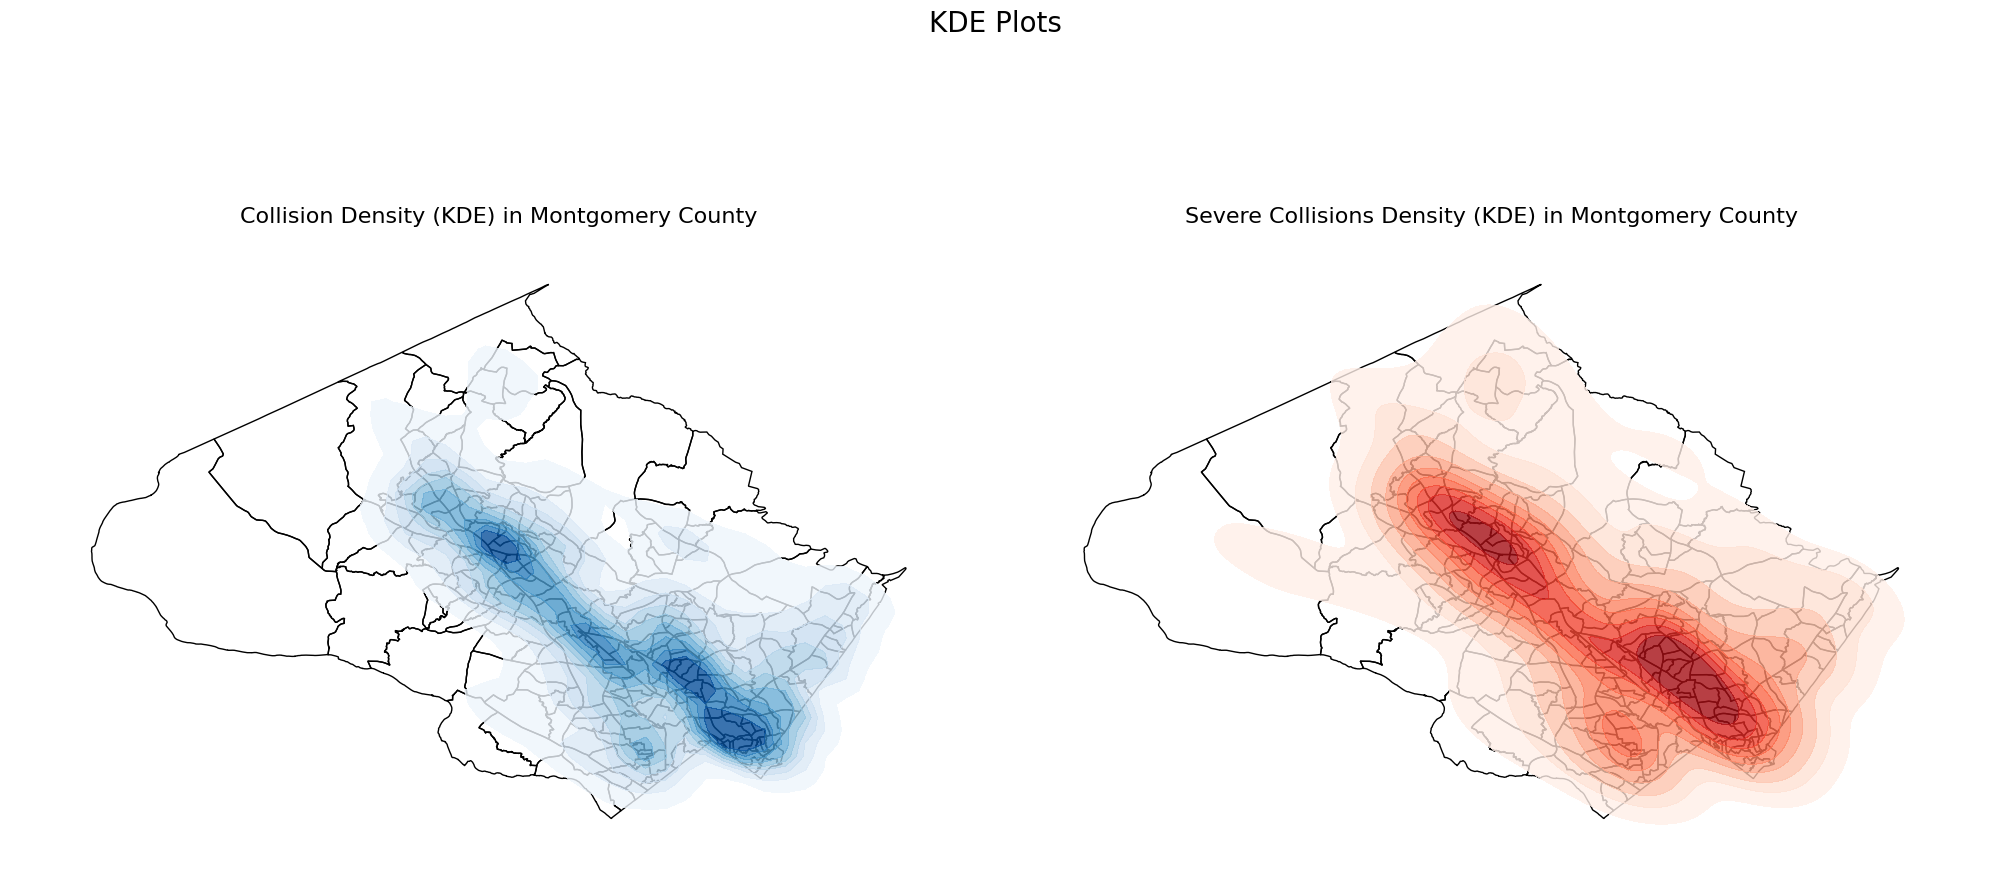

In [144]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

# Plot 1: Collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf.sample(40_000),
    shade=True,
    shade_lowest=False,
    cmap="Blues",
    alpha=0.8,
    ax=axes[0]
)
geoplot.polyplot(montgomery_tracts, ax=axes[0], edgecolor="black")
axes[0].set_title("Collision Density (KDE) in Montgomery County", fontsize=16)

# Plot 2: Severe collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf[crashes_with_tracts_gdf["severity"] == 1],
    shade=True,
    shade_lowest=False,
    cmap="Reds",
    alpha=0.8,
    ax=axes[1]
)
geoplot.polyplot(montgomery_tracts, ax=axes[1], edgecolor="black")
axes[1].set_title("Severe Collisions Density (KDE) in Montgomery County", fontsize=16)

fig.suptitle("KDE Plots", fontsize=20, y=1.02)
# Show the combined plots
plt.tight_layout()
plt.show()


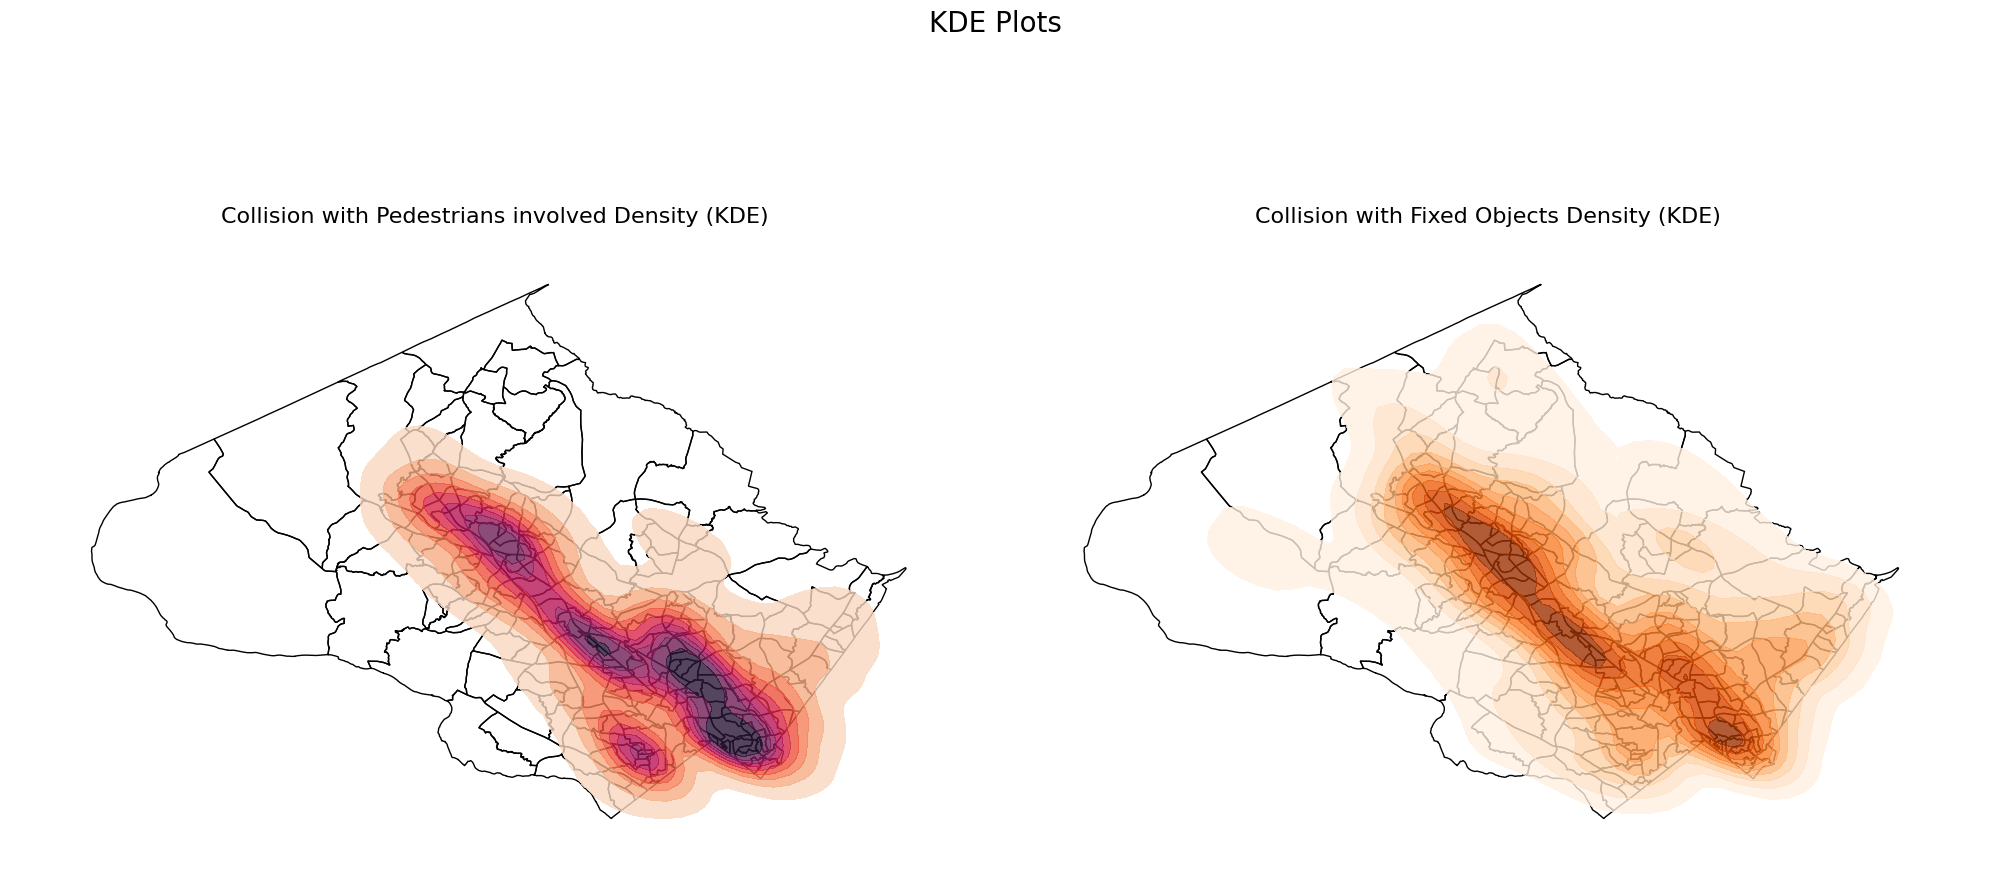

In [145]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

# Plot 1: Collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf[crashes_with_tracts_gdf["first_harmful_event"] == "PEDESTRIAN"],
    shade=True,
    shade_lowest=False,
    cmap="rocket_r",
    alpha=0.8,
    ax=axes[0]
)
geoplot.polyplot(montgomery_tracts, ax=axes[0], edgecolor="black")
axes[0].set_title("Collision with Pedestrians involved Density (KDE) ", fontsize=16)

# Plot 2: Severe collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf[crashes_with_tracts_gdf["first_harmful_event"] == "FIXED OBJECT"],
    shade=True,
    shade_lowest=False,
    cmap="Oranges",
    alpha=0.8,
    ax=axes[1]
)
geoplot.polyplot(montgomery_tracts, ax=axes[1], edgecolor="black")
axes[1].set_title("Collision with Fixed Objects Density (KDE) ", fontsize=16)

fig.suptitle("KDE Plots", fontsize=20, y=1.02)
# Show the combined plots
plt.tight_layout()
plt.show()


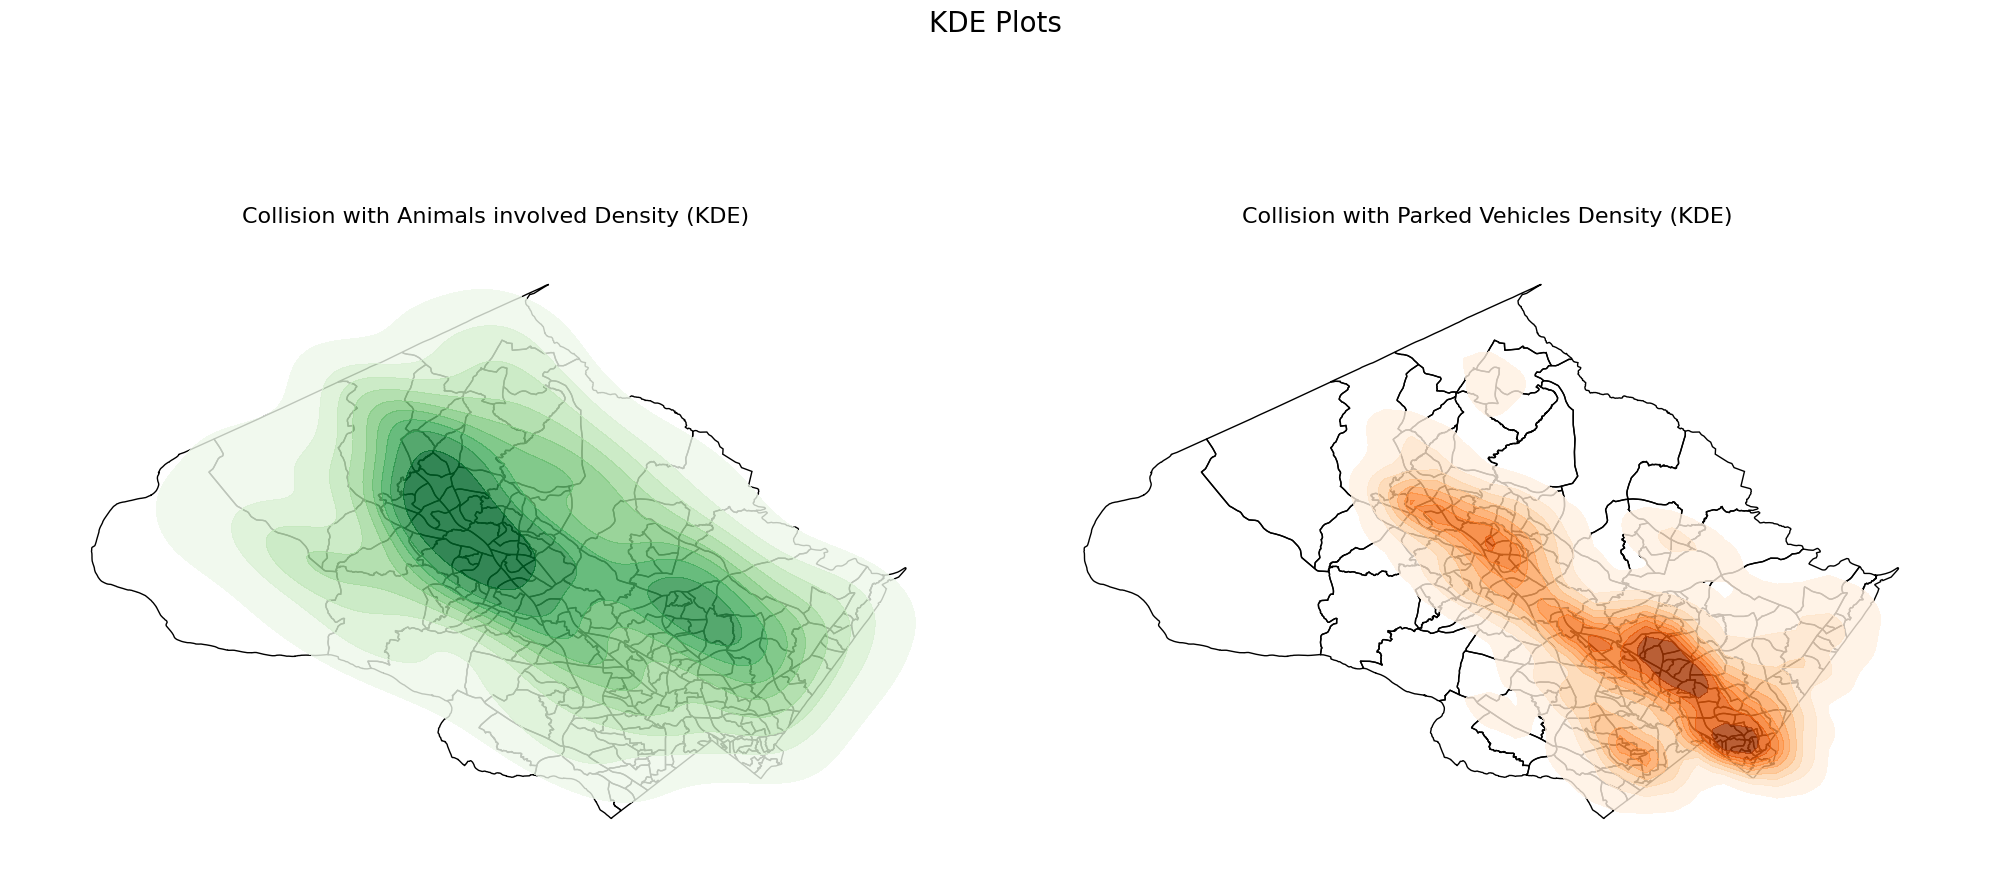

In [146]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

# Plot 1: Collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf[crashes_with_tracts_gdf["first_harmful_event"] == "ANIMAL"],
    shade=True,
    shade_lowest=False,
    cmap="Greens",
    alpha=0.8,
    ax=axes[0]
)
geoplot.polyplot(montgomery_tracts, ax=axes[0], edgecolor="black")
axes[0].set_title("Collision with Animals involved Density (KDE) ", fontsize=16)

# Plot 2: Severe collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf[crashes_with_tracts_gdf["first_harmful_event"] == "PARKED VEHICLE"],
    shade=True,
    shade_lowest=False,
    cmap="Oranges",
    alpha=0.8,
    ax=axes[1]
)
geoplot.polyplot(montgomery_tracts, ax=axes[1], edgecolor="black")
axes[1].set_title("Collision with Parked Vehicles Density (KDE) ", fontsize=16)

fig.suptitle("KDE Plots", fontsize=20, y=1.02)
# Show the combined plots
plt.tight_layout()
plt.show()


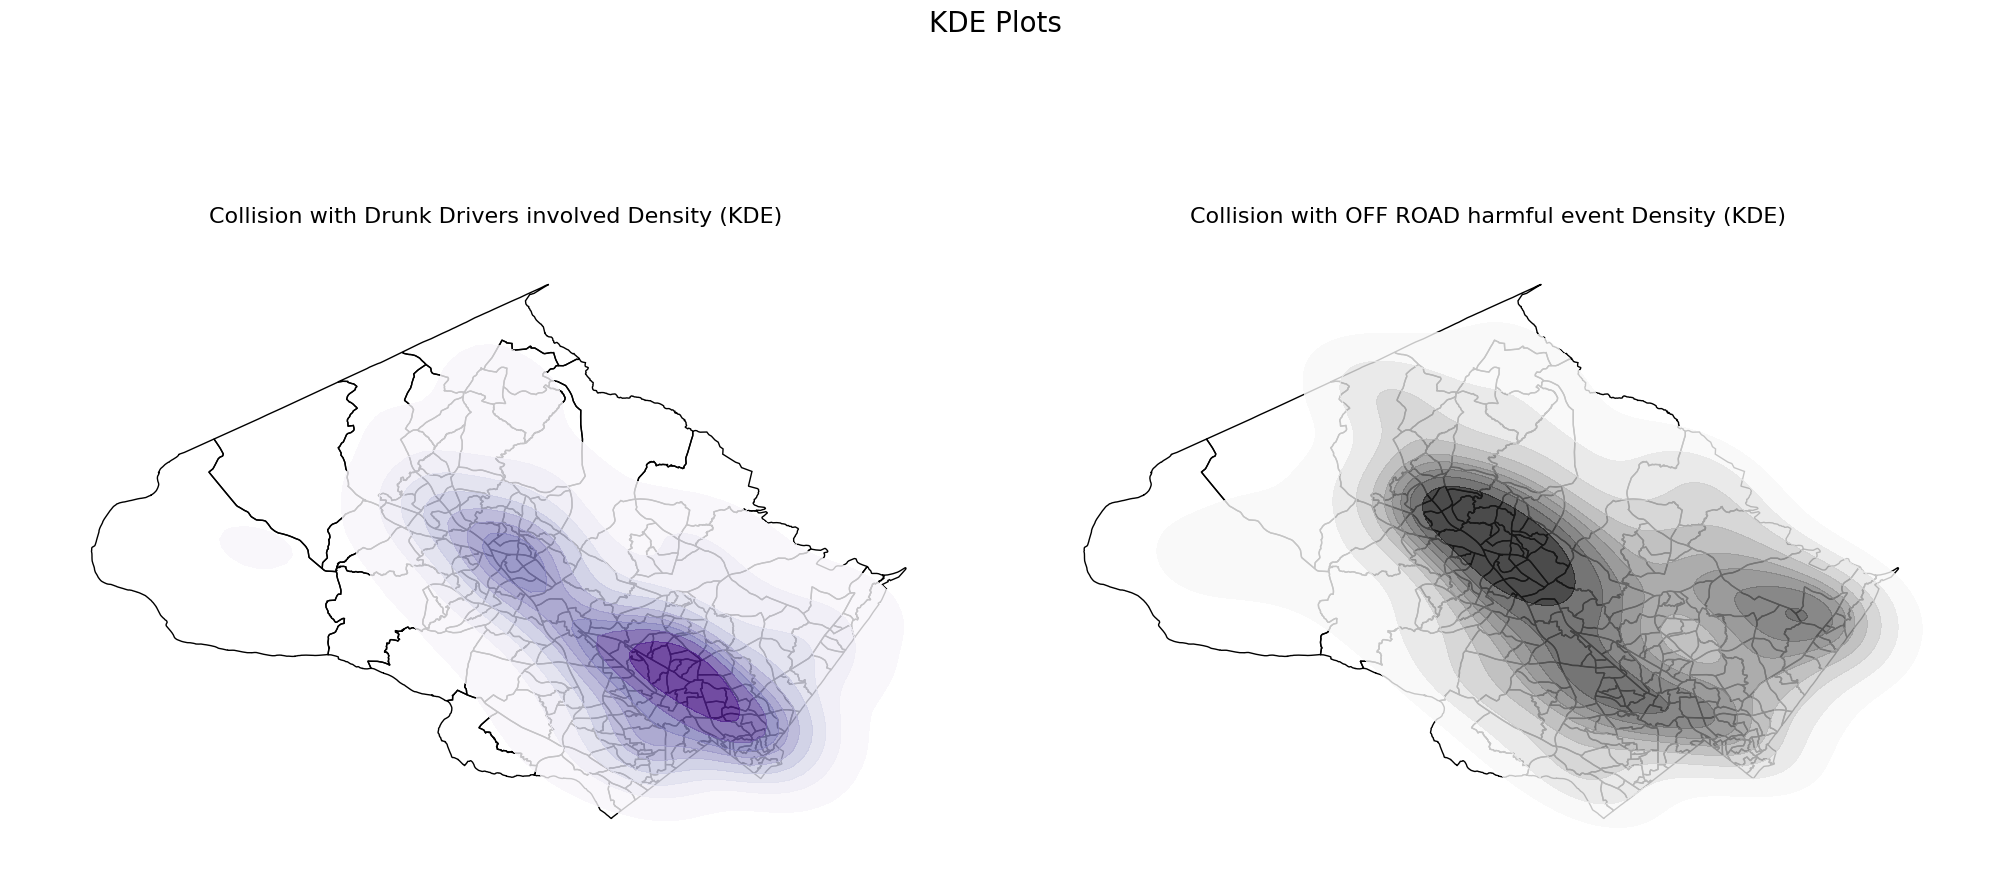

In [150]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

# Plot 1: Collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf[crashes_with_tracts_gdf["is_alcohol_present_driver"] == 1],
    shade=True,
    shade_lowest=False,
    cmap="Purples",
    alpha=0.8,
    ax=axes[0]
)
geoplot.polyplot(montgomery_tracts, ax=axes[0], edgecolor="black")
axes[0].set_title("Collision with Drunk Drivers involved Density (KDE) ", fontsize=16)

# Plot 2: Severe collision density (KDE)
geoplot.kdeplot(
    crashes_with_tracts_gdf[crashes_with_tracts_gdf["first_harmful_event"] == "OFF ROAD"],
    shade=True,
    shade_lowest=False,
    cmap="Grays",
    alpha=0.8,
    ax=axes[1]
)
geoplot.polyplot(montgomery_tracts, ax=axes[1], edgecolor="black")
axes[1].set_title("Collision with OFF ROAD harmful event Density (KDE) ", fontsize=16)

fig.suptitle("KDE Plots", fontsize=20, y=1.02)
# Show the combined plots
plt.tight_layout()
plt.show()


#### Closer look at collisions in most dense areas (cities)